# International House Sales and Buyer Loan Prediction

Muh Amri Sidiq

## Introduction

This portfolio project dives into a comprehensive dataset titled 'International House Sales and Buyer Loan Records,' aiming to uncover crucial insights into the global real estate market and associated financial activities. The core objective of this analysis is to leverage statistical modeling and machine learning techniques to understand the factors driving house sales prices and to predict the likelihood of a loan application being approved for potential international buyers.

Using Python's data science ecosystem (including pandas, scikit-learn, and seaborn), this project demonstrates proficiency in the end-to-end data science lifecycle: from data cleaning and feature engineering to exploratory data analysis (EDA) and the development of predictive models (e.g., Regression for pricing and Classification for loan approval). The final output provides actionable intelligence for financial institutions to assess risk and for real estate agencies to optimize pricing strategies in the competitive international market.

## Install Library

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold, GridSearchCV
import re
import joblib
import nltk
from sklearn.metrics import (accuracy_score, classification_report, 
roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay, 
precision_recall_curve,average_precision_score, precision_score, recall_score)
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Read and Data Understanding

In [2]:
%%time
df = pd.read_csv('/kaggle/input/international-house-sales-and-buyer-loan-records/global_house_purchase_dataset.csv')

CPU times: user 497 ms, sys: 114 ms, total: 611 ms
Wall time: 980 ms


check preview data

In [3]:
df.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   property_id              200000 non-null  int64  
 1   country                  200000 non-null  object 
 2   city                     200000 non-null  object 
 3   property_type            200000 non-null  object 
 4   furnishing_status        200000 non-null  object 
 5   property_size_sqft       200000 non-null  int64  
 6   price                    200000 non-null  int64  
 7   constructed_year         200000 non-null  int64  
 8   previous_owners          200000 non-null  int64  
 9   rooms                    200000 non-null  int64  
 10  bathrooms                200000 non-null  int64  
 11  garage                   200000 non-null  int64  
 12  garden                   200000 non-null  int64  
 13  crime_cases_reported     200000 non-null  int64  
 14  lega

Insight: dta have 200000 row and 25 column without missing values

In [5]:
df.duplicated().sum()

0

Insight: No have duplicated data

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is the process of analyzing and summarizing datasets to understand their main characteristics before applying machine learning models or statistical tests. EDA helps identify patterns, detect anomalies, check assumptions, and gain insights using visualizations and statistical methods

In [6]:
df.describe()

,property_id,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
count,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,2.000000e+05,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,100000.500000,3195.633460,1.215365e+06,1991.487770,3.001370,4.513855,2.760030,0.499350,0.500215,1.229065,...,46528.625830,7.597583e+05,19.986375,10559.693105,4.556068e+05,0.195387,5.498650,5.505240,5.495615,0.230340
std,57735.171256,1613.322287,8.236633e+05,18.494064,2.002198,2.295669,1.840959,0.500001,0.500001,1.185336,...,27997.353766,5.489401e+05,7.081080,5427.241879,3.629865e+05,0.219689,2.875361,2.870945,2.870206,0.421052
min,1.000000,400.000000,5.628800e+04,1960.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,2000.000000,2.350400e+04,10.000000,500.000000,8.966000e+03,0.000000,1.000000,1.000000,1.000000,0.000000
25%,50000.750000,1802.000000,5.659895e+05,1975.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,...,21450.000000,3.372802e+05,15.000000,5770.000000,1.849592e+05,0.070000,3.000000,3.000000,3.000000,0.000000
50%,100000.500000,3190.000000,1.023429e+06,1991.000000,3.000000,5.000000,2.000000,0.000000,1.000000,1.000000,...,41465.000000,6.269325e+05,20.000000,10520.000000,3.561700e+05,0.130000,5.000000,5.000000,5.000000,0.000000
75%,150000.250000,4589.000000,1.725556e+06,2008.000000,5.000000,7.000000,4.000000,1.000000,1.000000,2.000000,...,70805.000000,1.058416e+06,25.000000,15260.000000,6.257352e+05,0.240000,8.000000,8.000000,8.000000,0.000000
max,200000.000000,6000.000000,4.202732e+06,2023.000000,6.000000,8.000000,8.000000,1.000000,1.000000,10.000000,...,100000.000000,3.520150e+06,30.000000,20000.000000,2.492723e+06,3.460000,10.000000,10.000000,10.000000,1.000000


Insight:

Based on the statistical summary, the dataset presents several high-variance and critical factors that drive the complexity and value of this analysis.

1. High Variance in the Real Estate Market
   - Price and Size Diversity: Property price is extremely volatile, ranging from a minimum of 56K USD to a maximum of 4.2 Million USD, with an average of 1.22 Million USD. This necessitates robust regression models to accurately capture the impact of diverse property characteristics.

   - Property Age Mix: The properties are relatively old on average (constructed_year around 1991), but the range extends from 1960 to 2023. The relationship between age and price will be a key exploratory analysis point.

   - Essential Features: Binary variables (garage and garden) have a mean close to 0.5, indicating that these features are present in approximately half of the total listings.

   - Location Risk: While the average crime_cases_reported is low (1.23), the maximum value of 10 highlights pockets of high-risk neighborhoods, which will likely correlate negatively with both property price and customer satisfaction.
  
2. Critical Financial and Loan Imbalances
   - Low Loan Approval Rate: The most significant finding is the heavily skewed decision variable. With a mean of 0.23, it implies that only about 23% of loan applications are approved, while 77% are rejected. This severe class imbalance is the central challenge for the classification model.

   - Substantial Down Payments: The average down_payment (455K USD) is approximately 60% of the average loan_amount (759K USD). This suggests that international buyers are generally well-capitalized or that the total property cost is significantly higher than the loan value.

   - Extreme Outlier Risk: The emi_to_income_ratio has a healthy average of 19.5% but a maximum value of 346%. This extreme outlier must be investigated and managed (e.g., capped or removed) during data cleaning, as it will drastically skew any financial risk model.

   - Widespread Income Range: Customer salaries are spread broadly (from 2K USD to 100K USD), demonstrating that the data captures a wide range of socioeconomic profiles, making the prediction of loan default more complex.
  
3. Neutral but Dispersed Locational Scores
   - The scores for satisfaction_score, neighbourhood_rating, and connectivity_score all hover around the neutral average of 5.5 (on a 1-10 scale).
   - However, their high standard deviation (2.9) shows that the ratings are not clustered around the average but are spread out. This indicates significant differentiation in neighborhood quality, which should be a strong predictor for price and, potentially, loan risk assessment.

In [7]:
df.describe(include = 'object')

,country,city,property_type,furnishing_status
count,200000,200000,200000,200000
unique,13,40,6,3
top,France,Singapore,Farmhouse,Fully-Furnished
freq,15628,15278,33518,66829


Insight:

1. Geographical Focus and Diversity
   - Dominant Country: Out of 200,000 entries, France is the most frequent country, accounting for 15,628 records. This strong presence suggests that the French market is a primary focus of the dataset or the specific lending institution being analyzed.

   - High City Diversity: The dataset is geographically broad, covering 406 distinct cities but only 13 different countries. This high ratio of unique cities to countries implies that the data heavily samples diverse locations within a limited number of nations, maximizing local variations.

   - Leading City: Singapore is the most frequent city, with 15,278 records. The fact that the top city (Singapore) and top country (France) are different suggests that while the overall dataset is dominated by a few countries, the specific data collection or marketing effort might be highly concentrated in specific global hubs like Singapore.

2. Property Type and Furnishing Trends
   - Leading Property Type: The most common property type is a 'Farmhouse,' with 33,518 records. This is a surprising finding for an "International House Sales" dataset, suggesting a strong focus on suburban or rural luxury properties rather than dense urban apartments.

   - Furnishing Status: The majority of properties are sold as 'Fully-Furnished,' with 66,829 records. This indicates that many of these international sales are targeting investors or second-home buyers who prefer a ready-to-move-in condition, which likely adds a premium to the sale price.

   - Strategic Feature Engineering: The high frequency of 'Farmhouse' and 'Fully-Furnished' should be considered as strong predictor variables in both the price prediction (Regression) and loan approval (Classification) models.

Text(0.5, 1.0, 'Heatmap Correlation')

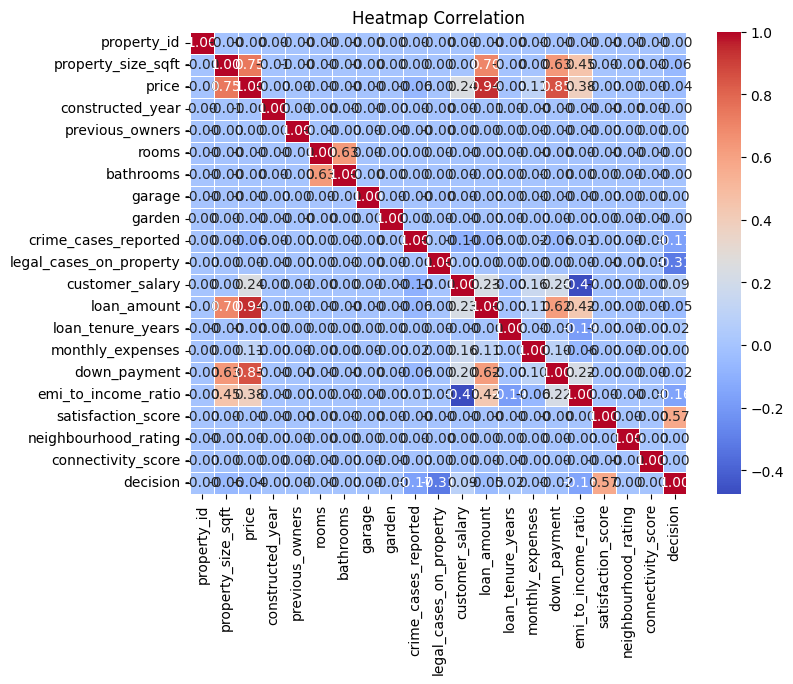

In [8]:
df_numeric = df.select_dtypes(include=['number'])

# Calculate correlation
corrtrain_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corrtrain_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation")

Insight: `decision` have positive correlation with `satisfaction_score`. `price` have positive correlation with `emi_to_income_ratio`, `down_payment` and `loan_amount`

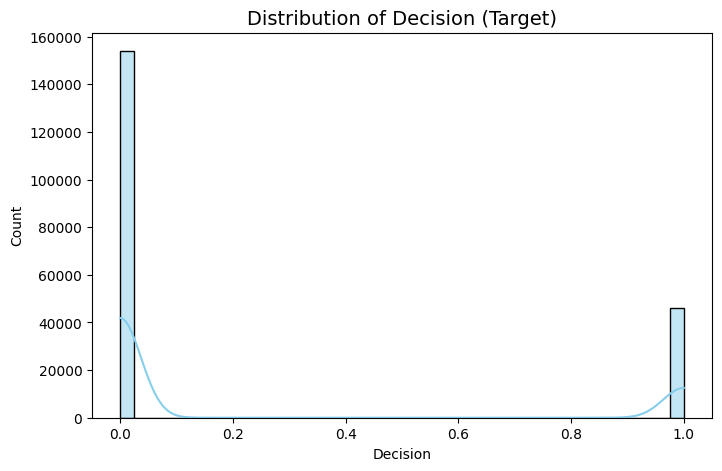

In [9]:
# --- Target Distribution: decision ---
plt.figure(figsize=(8,5))
sns.histplot(df["decision"], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Decision (Target)", fontsize=14)
plt.xlabel("Decision")
plt.ylabel("Count")
plt.show()

Insight: target is not balance

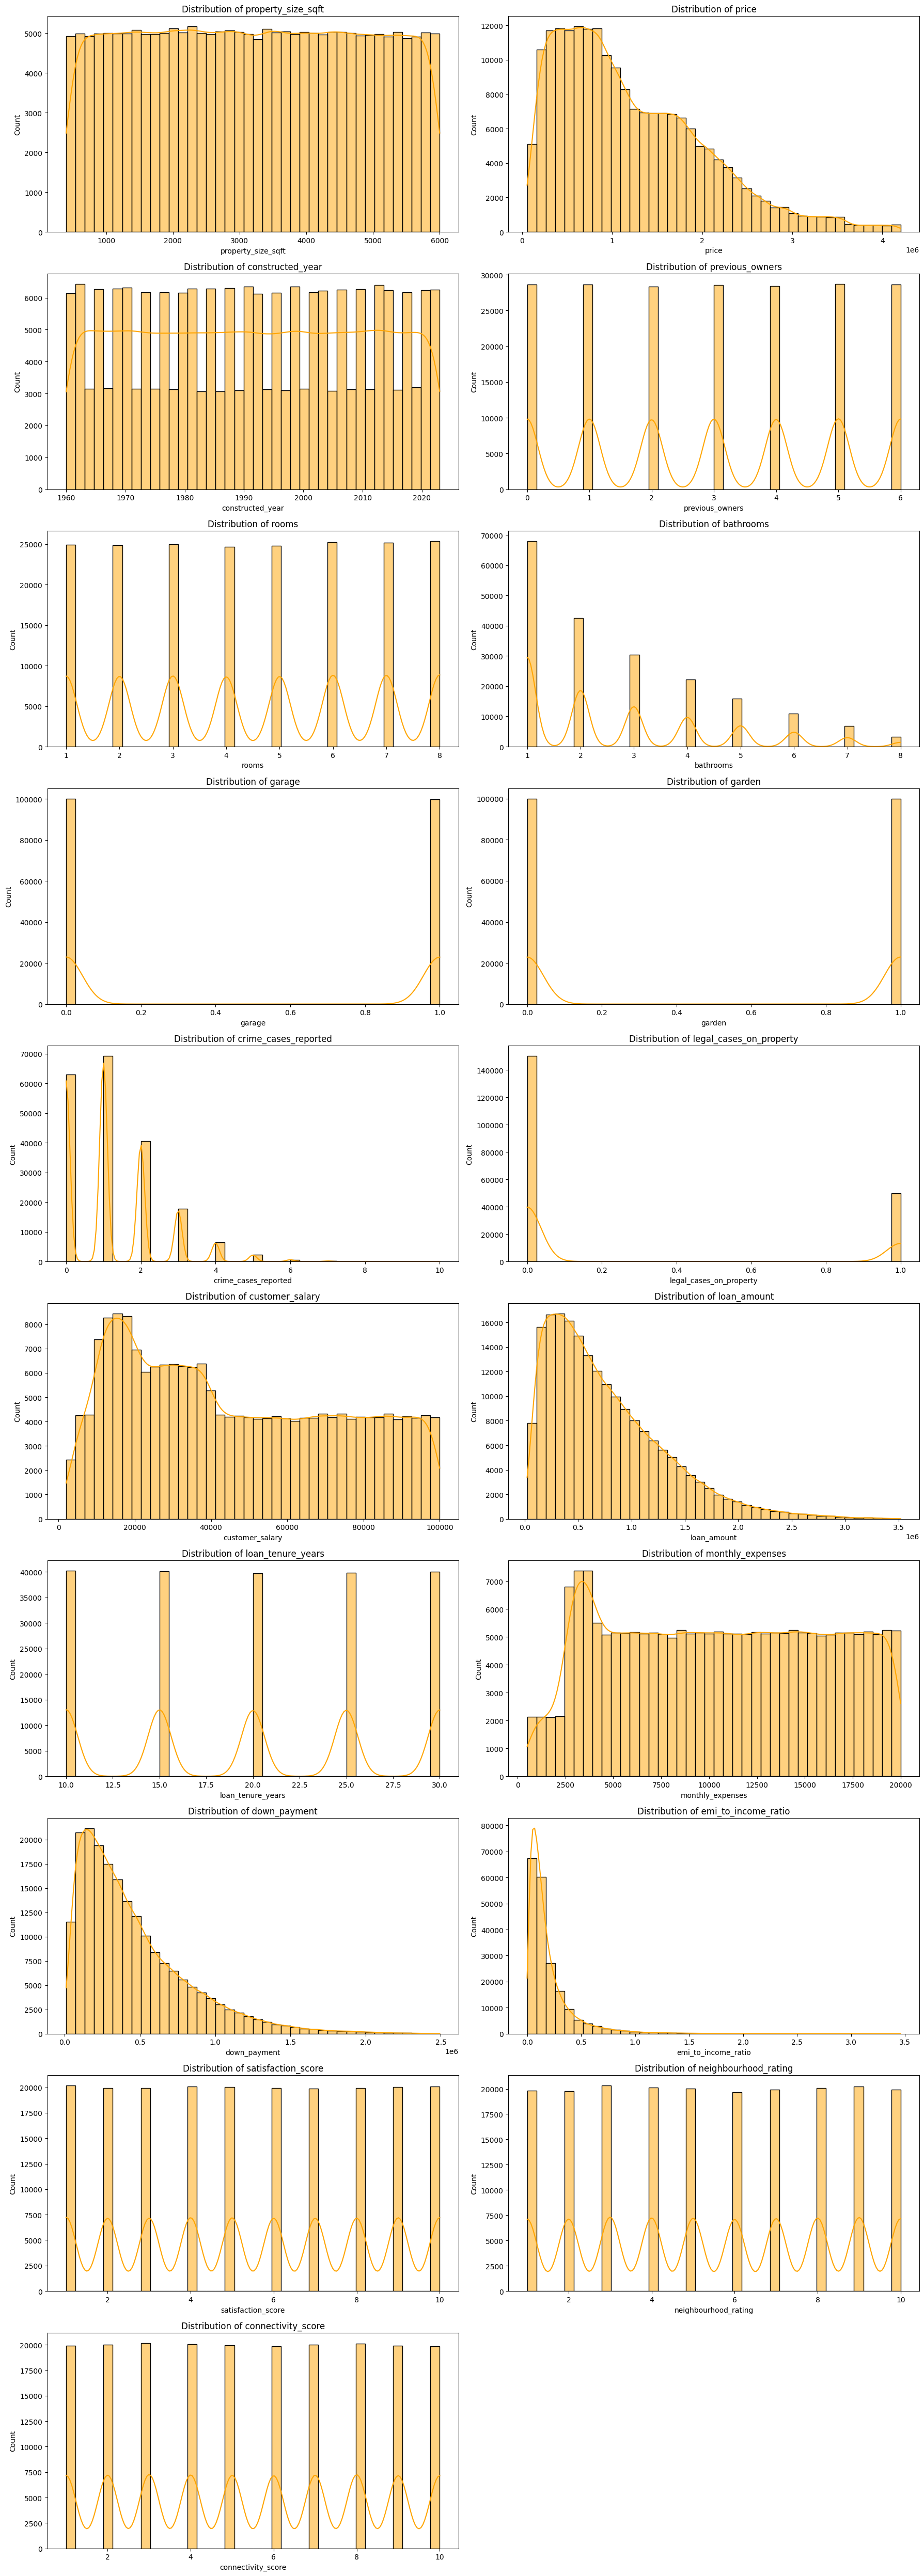

In [10]:
exclude_cols = ["property_id", "decision"]

num_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_cols = [c for c in num_cols if c not in exclude_cols]

n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for i, col in enumerate(num_cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]   # handle single row
    sns.histplot(df[col], bins=40, kde=True, color="orange", ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for j in range(len(num_cols), n_rows * n_cols):
    r, c = divmod(j, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()

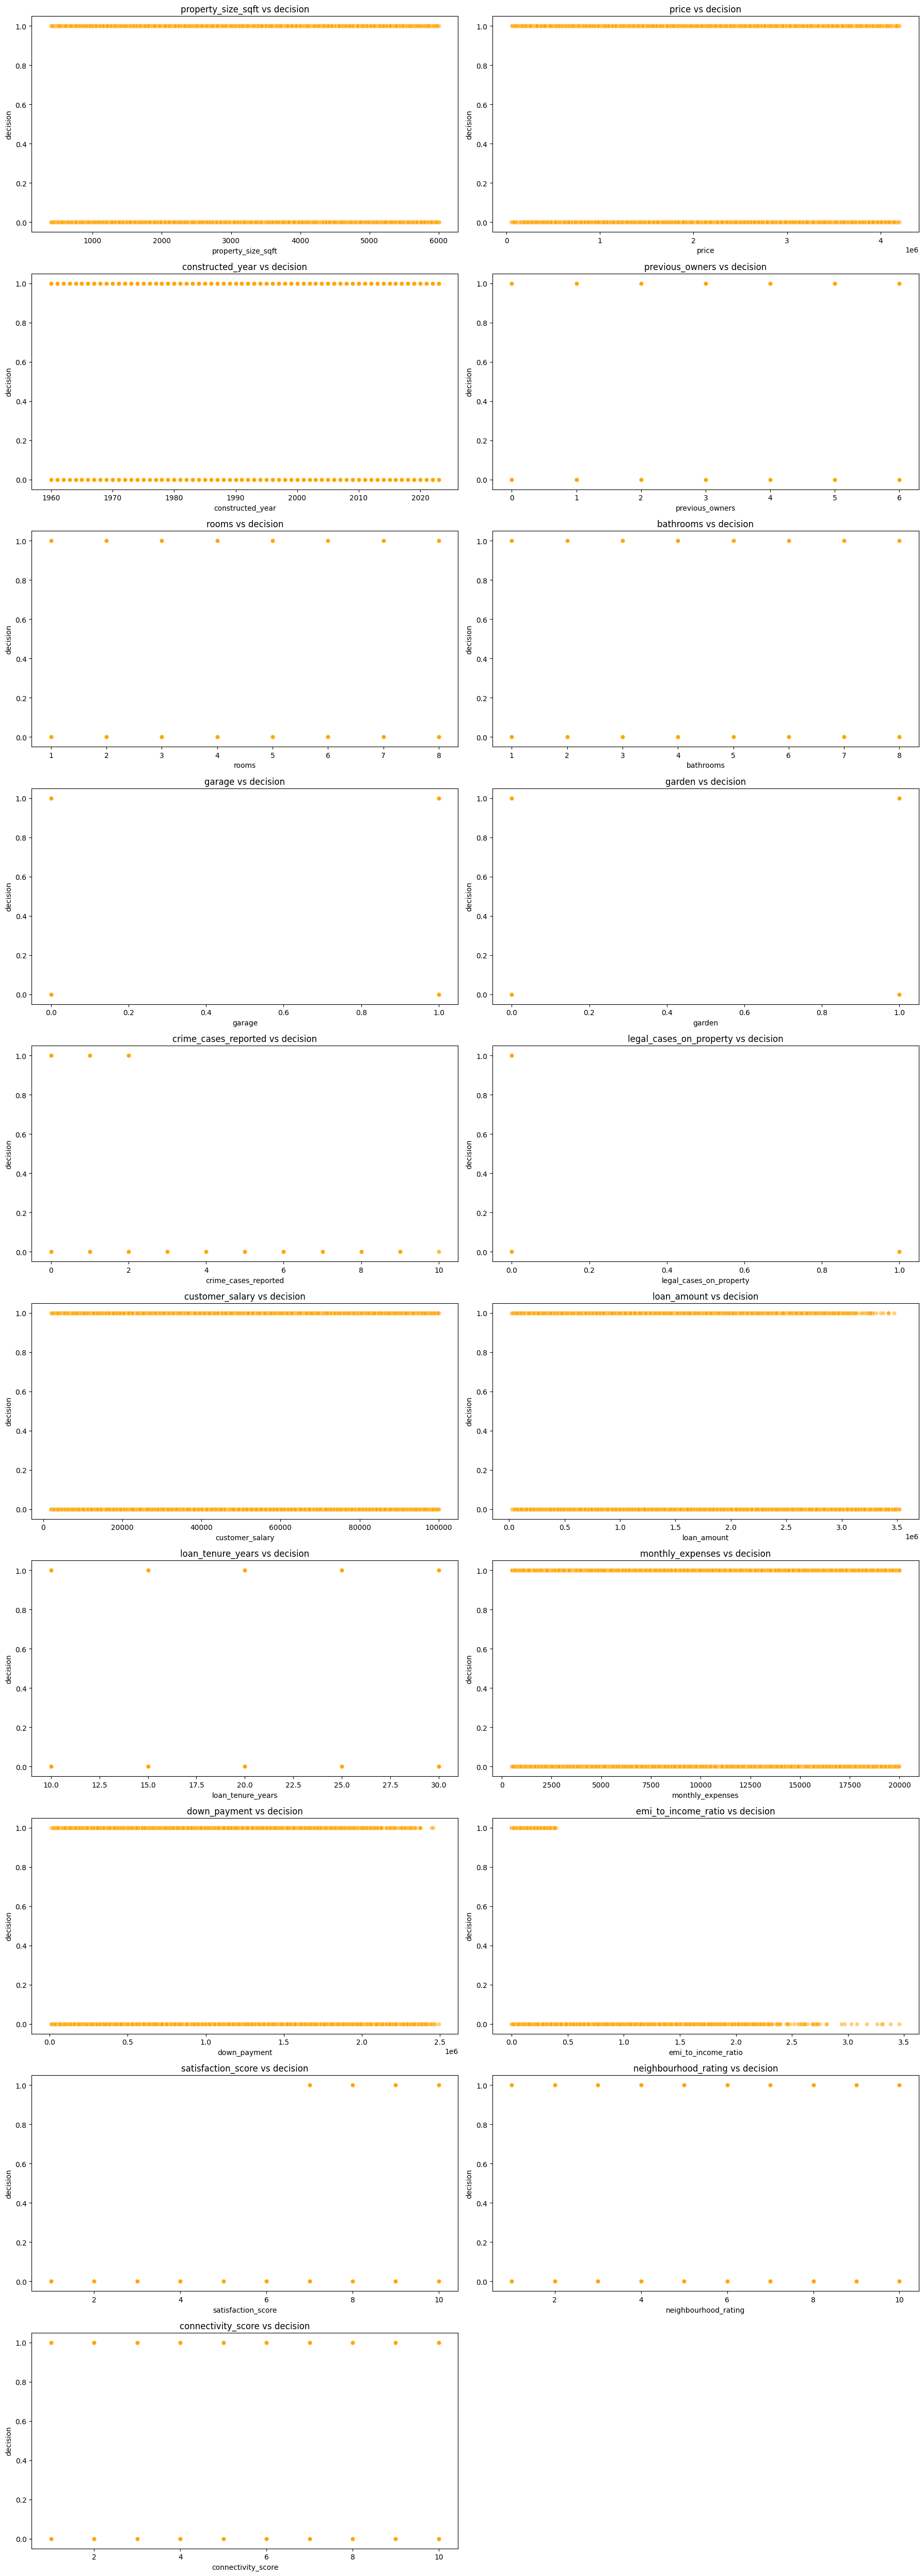

In [11]:
# --- Numerical Features vs Target (Scatter Plot) ---
exclude_cols = ["property_id", "decision"]
target_col = "decision"

num_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_cols = [c for c in num_cols if c not in exclude_cols]

n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for i, col in enumerate(num_cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]   # handle single row
    
    sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5, color="orange", ax=ax)
    ax.set_title(f"{col} vs {target_col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)

for j in range(len(num_cols), n_rows * n_cols):
    r, c = divmod(j, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()

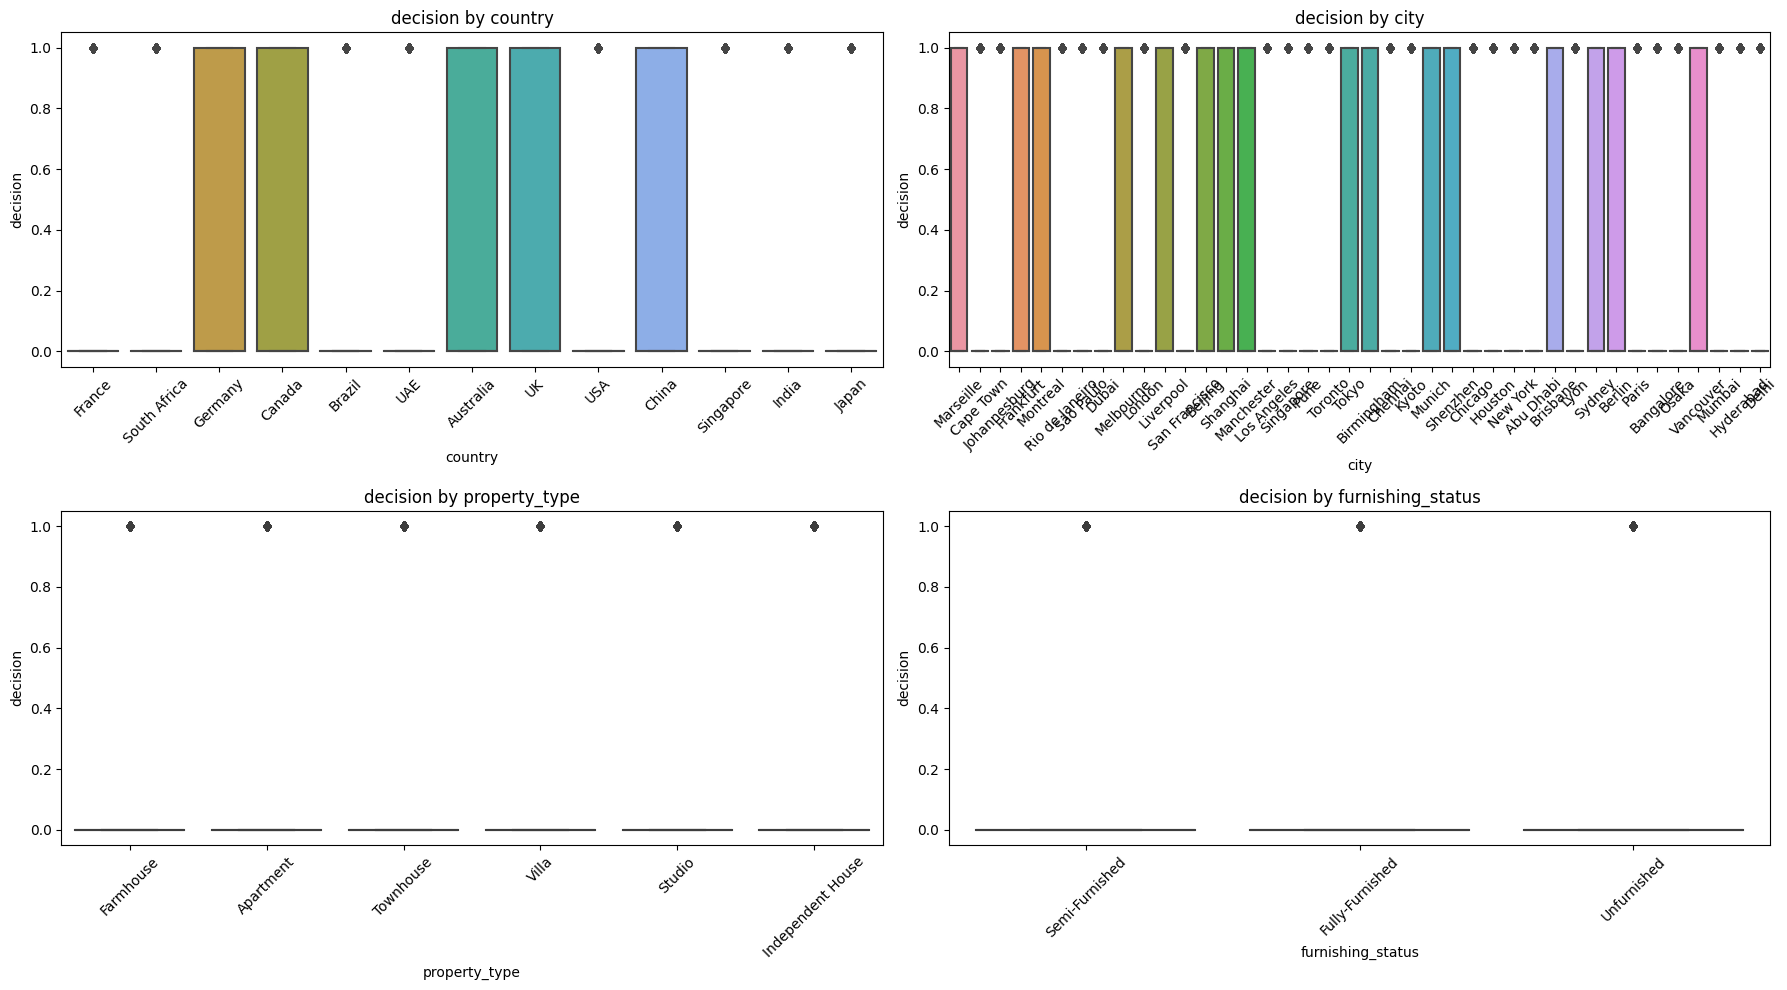

In [12]:
# --- Categorical Features vs Numeric Target ---
exclude_cols = ["property_id"]   # contoh exclude
target_col = "decision"  # target numerik

cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols = [c for c in cat_cols if c not in exclude_cols]

n_cols = 2
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for i, col in enumerate(cat_cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    
    sns.boxplot(x=df[col], y=df[target_col], ax=ax)
    ax.set_title(f"{target_col} by {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.tick_params(axis="x", rotation=45)

# hapus subplot kosong
for j in range(len(cat_cols), n_rows * n_cols):
    r, c = divmod(j, n_cols)
    fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])

plt.tight_layout()
plt.show()

## Feature Engineering

In [13]:
# For features that may be skewed
skewed_features = ['price', 'bathrooms', 'crime_cases_reported', 'customer_salary',
                  'loan_amount', 'down_payment', 'emi_to_income_ratio']

for feature in skewed_features:
    df[feature+'_log'] = np.log1p(df[feature])

# Age of Property
current_year = 2025
df['property_age'] = current_year - df['constructed_year']
df['property_age_group'] = pd.cut(df['property_age'], 
                                 bins=[0, 5, 10, 20, 50, 100],
                                 labels=['new', 'recent', 'medium', 'old', 'very_old'])

# Property Size Categories
df['property_size_category'] = pd.cut(df['property_size_sqft'],
                                     bins=[0, 500, 1000, 1500, 2000, float('inf')],
                                     labels=['small', 'medium', 'large', 'xlarge', 'xxlarge'])

# Financials ratio
df['loan_to_value_ratio'] = df['loan_amount'] / (df['loan_amount'] + df['down_payment'])
df['debt_to_income_ratio'] = (df['monthly_expenses'] + (df['loan_amount'] / df['loan_tenure_years'] / 12)) / df['customer_salary']
df['savings_ratio'] = (df['customer_salary'] - df['monthly_expenses']) / df['customer_salary']

# Room Density
df['area_per_room'] = df['property_size_sqft'] / df['rooms']
df['bathroom_ratio'] = df['bathrooms'] / df['rooms']

# Interaction between property and finance
df['luxury_index'] = df['property_size_sqft'] * df['neighbourhood_rating']
df['affordability_score'] = df['customer_salary'] / (df['price'] / 1000)

# The interaction between crime and the surrounding environment
df['safety_score'] = df['neighbourhood_rating'] / (df['crime_cases_reported'] + 1)

# Seasonal/Periodic patterns based on constructed_year
df['construction_decade'] = (df['constructed_year'] // 10) * 10
df['is_modern_property'] = (df['constructed_year'] > 2000).astype(int)

# Aggregation by location (if the dataset is large enough)
location_stats = df.groupby('city').agg({
    'price': ['mean', 'median', 'std'],
    'crime_cases_reported': 'mean',
    'neighbourhood_rating': 'mean'
}).round(2)

location_stats.columns = ['_'.join(col).strip() for col in location_stats.columns.values]
df = df.merge(location_stats, on='city', how='left')

# Risk Assesment feature
df['legal_risk'] = df['legal_cases_on_property'].apply(lambda x: 1 if x > 0 else 0)
df['financial_risk'] = (df['emi_to_income_ratio'] > 0.4).astype(int)
df['property_risk'] = (df['property_age'] > 50).astype(int)

# composites scores
df['overall_property_score'] = (
    df['neighbourhood_rating'] * 0.3 +
    df['connectivity_score'] * 0.3 +
    df['satisfaction_score'] * 0.2 +
    (1 - df['crime_cases_reported'] / df['crime_cases_reported'].max()) * 0.2
)

## Clustering

In [14]:
# Select meaningful features for property segmentation
clustering_features = [
    # 1. Karakteristik Properti
    'property_size_sqft',
    'price',
    'property_age',
    'rooms',
    'bathrooms',
    
    # 2. Location & Environment
    'neighbourhood_rating',
    'connectivity_score',
    'safety_score',
    'crime_cases_reported',
    
    # 3. Finansial Customer
    'customer_salary',
    'loan_amount',
    'emi_to_income_ratio',
    'affordability_score',
    
    # 4. Risk
    'legal_risk',
    'financial_risk',
    'overall_property_score',
    
    # 5. Fasilitas
    'garage',
    'garden'
]

print(f"From 54 feature, chose {len(clustering_features)} most relevant feature")

# Prepare feature matrix
X_cluster = df[clustering_features].copy()

# Check for missing values
print(f"Missing values in features: {X_cluster.isnull().sum().sum()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)

print(f"✅ Data prepared: {X_scaled_df.shape}")
print(f"✅ Features standardized")

From 54 feature, chose 18 most relevant feature
Missing values in features: 0
✅ Data prepared: (200000, 18)
✅ Features standardized


In [15]:
# Range of clusters to try
k_range = range(2, 11)
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    # Calculate metrics
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}: WCSS = {kmeans.inertia_:.2f}, Silhouette = {silhouette_avg:.3f}")

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal number of clusters: {optimal_k} (based on silhouette score)")

Testing different numbers of clusters...
K=2: WCSS = 3147626.04, Silhouette = 0.120
K=3: WCSS = 2849727.45, Silhouette = 0.118
K=4: WCSS = 2656793.08, Silhouette = 0.106
K=5: WCSS = 2521481.54, Silhouette = 0.102
K=6: WCSS = 2427713.34, Silhouette = 0.097
K=7: WCSS = 2351060.05, Silhouette = 0.092
K=8: WCSS = 2293069.09, Silhouette = 0.086
K=9: WCSS = 2242594.49, Silhouette = 0.086
K=10: WCSS = 2196857.48, Silhouette = 0.084

🎯 Optimal number of clusters: 2 (based on silhouette score)


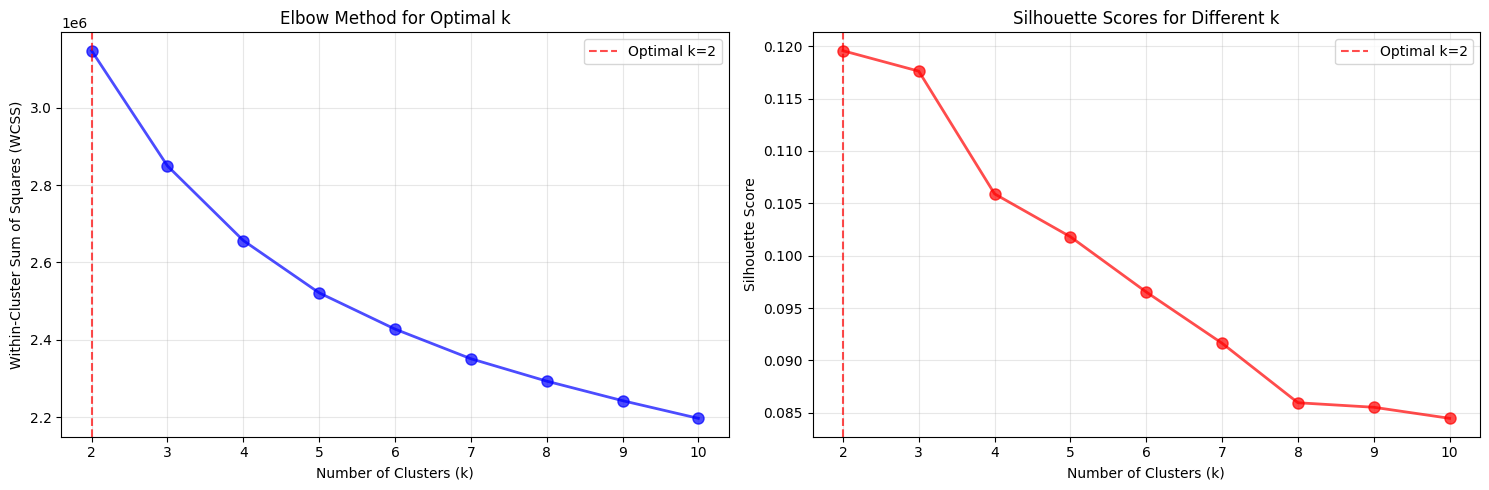

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8, alpha=0.7)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
ax1.legend()

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8, alpha=0.7)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores for Different k')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.show()

Apply K-Means With Optimal K

In [17]:
# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels
X_scaled_df['cluster'] = cluster_labels

print("✅ K-Means clustering completed")
print(f"✅ Cluster distribution:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   Cluster {cluster_id}: {count} House ({percentage:.1f}%)")

✅ K-Means clustering completed
✅ Cluster distribution:
   Cluster 0: 112079 House (56.0%)
   Cluster 1: 87921 House (44.0%)


Dimensionality Reduction For Visualization

PCA explained variance: 0.329


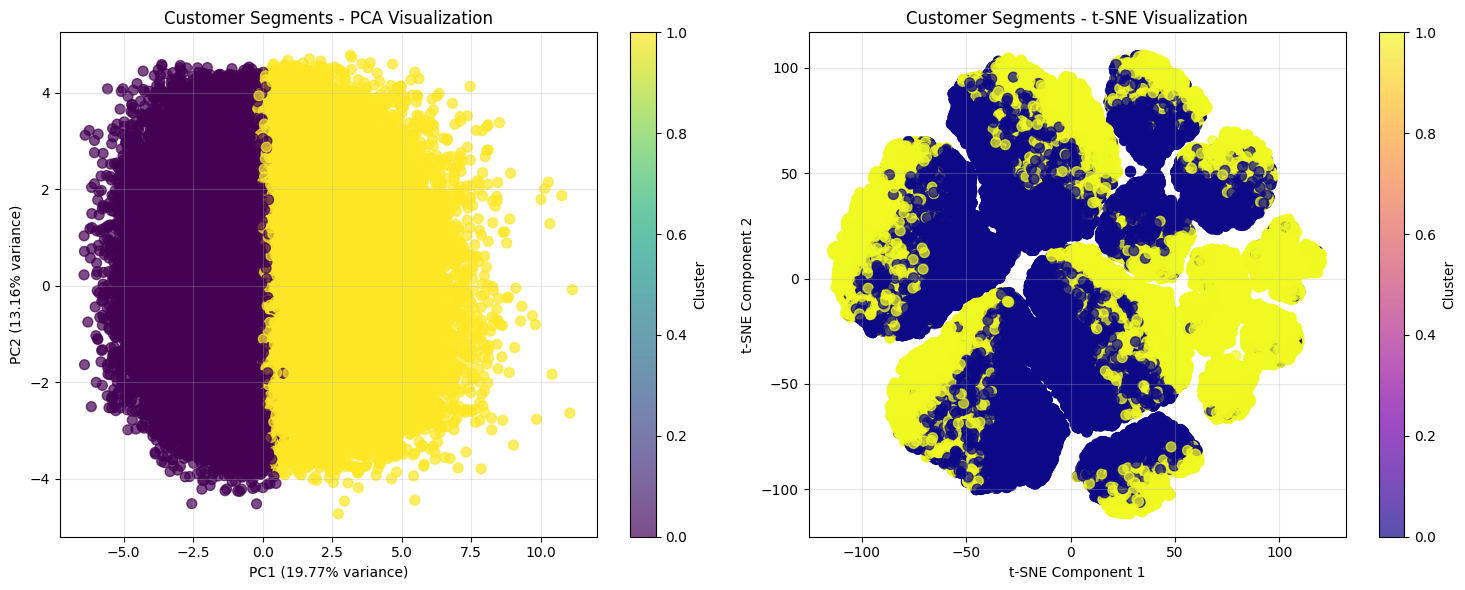

In [18]:
# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['cluster'] = cluster_labels

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PCA Visualization
scatter1 = ax1.scatter(df_pca['PC1'], df_pca['PC2'], c=cluster_labels, 
                      cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('Customer Segments - PCA Visualization')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Apply t-SNE for alternative visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = cluster_labels

# t-SNE Visualization
scatter2 = ax2.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=cluster_labels, 
                      cmap='plasma', alpha=0.7, s=50)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_title('Customer Segments - t-SNE Visualization')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.savefig('kmeans_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

Cluster Profiling & Analysis

In [19]:
# Calculate cluster characteristics
cluster_profile = df.groupby('cluster')[clustering_features + ['decision']].mean()

# Add basic statistics
cluster_profile['cluster_size'] = df.groupby('cluster').size()
cluster_profile['decision_rate'] = df.groupby('cluster')['decision'].mean()

print("\n📊 Cluster Profiles (Mean Values):")
print(cluster_profile.round(3))


📊 Cluster Profiles (Mean Values):
         property_size_sqft        price  property_age  rooms  bathrooms  \
cluster                                                                    
0                  2089.306   677924.379        33.381  4.523      2.764   
1                  4605.946  1900478.145        33.679  4.503      2.755   

         neighbourhood_rating  connectivity_score  safety_score  \
cluster                                                           
0                       5.465               5.466         3.142   
1                       5.557               5.534         3.336   

         crime_cases_reported  customer_salary  ...  emi_to_income_ratio  \
cluster                                         ...                        
0                       1.278        46365.619  ...                0.099   
1                       1.167        46736.422  ...                0.318   

         affordability_score  legal_risk  financial_risk  \
cluster                   

Detail Cluster Interpretation & Nameing

In [20]:
# Analyze each cluster's characteristics for property segmentation
cluster_descriptions = []

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    cluster_profile = df[df['cluster'] == cluster_id][clustering_features].mean()
    
    # Calculate key metrics for each cluster
    characteristics = {
        'cluster_id': cluster_id,
        'size': len(cluster_data),
        'size_percentage': len(cluster_data) / len(df) * 100,
        'decision_rate': cluster_data['decision'].mean() if 'decision' in df.columns else 0.5,
        
        # Property Characteristics
        'luxury_properties': cluster_profile['price'] > df[clustering_features]['price'].median(),
        'large_properties': cluster_profile['property_size_sqft'] > df[clustering_features]['property_size_sqft'].median(),
        'new_properties': cluster_profile['property_age'] < df[clustering_features]['property_age'].median(),
        'multi_room_properties': cluster_profile['rooms'] > df[clustering_features]['rooms'].median(),
        
        # Location Quality
        'premium_locations': cluster_profile['neighbourhood_rating'] > df[clustering_features]['neighbourhood_rating'].median(),
        'well_connected': cluster_profile['connectivity_score'] > df[clustering_features]['connectivity_score'].median(),
        'safe_areas': cluster_profile['safety_score'] > df[clustering_features]['safety_score'].median(),
        'low_crime': cluster_profile['crime_cases_reported'] < df[clustering_features]['crime_cases_reported'].median(),
        
        # Financial Profile
        'high_income_buyers': cluster_profile['customer_salary'] > df[clustering_features]['customer_salary'].median(),
        'large_loans': cluster_profile['loan_amount'] > df[clustering_features]['loan_amount'].median(),
        'high_affordability': cluster_profile['affordability_score'] > df[clustering_features]['affordability_score'].median(),
        'high_emi_ratio': cluster_profile['emi_to_income_ratio'] > df[clustering_features]['emi_to_income_ratio'].median(),
        
        # Risk Profile
        'high_legal_risk': cluster_profile['legal_risk'] > df[clustering_features]['legal_risk'].median(),
        'high_financial_risk': cluster_profile['financial_risk'] > df[clustering_features]['financial_risk'].median(),
        'high_property_score': cluster_profile['overall_property_score'] > df[clustering_features]['overall_property_score'].median(),
        
        # Amenities
        'with_garage': cluster_profile['garage'] > df[clustering_features]['garage'].median(),
        'with_garden': cluster_profile['garden'] > df[clustering_features]['garden'].median()
    }
    
    # Calculate actual values for detailed description
    actual_values = {
        'avg_price': cluster_profile['price'],
        'avg_size': cluster_profile['property_size_sqft'],
        'avg_age': cluster_profile['property_age'],
        'avg_rooms': cluster_profile['rooms'],
        'avg_salary': cluster_profile['customer_salary'],
        'avg_loan': cluster_profile['loan_amount'],
        'avg_affordability': cluster_profile['affordability_score'],
        'avg_rating': cluster_profile['neighbourhood_rating']
    }
    
    characteristics.update(actual_values)
    
    # Assign cluster name based on property characteristics
    if (characteristics['luxury_properties'] and characteristics['premium_locations'] and 
        characteristics['high_income_buyers']):
        cluster_name = "Premium Luxury Segment"
    elif (characteristics['large_properties'] and characteristics['multi_room_properties'] and 
          characteristics['with_garden']):
        cluster_name = "Family Home Seekers"
    elif (characteristics['high_affordability'] and characteristics['low_crime'] and 
          not characteristics['luxury_properties']):
        cluster_name = "Value-Conscious Buyers"
    elif (characteristics['high_legal_risk'] or characteristics['high_financial_risk']):
        cluster_name = "High-Risk Properties"
    elif (characteristics['new_properties'] and characteristics['well_connected'] and 
          characteristics['with_garage']):
        cluster_name = "Modern Urban Dwellers"
    elif (characteristics['large_loans'] and characteristics['high_emi_ratio']):
        cluster_name = "High-Leverage Investors"
    else:
        cluster_name = f"Mixed Segment {cluster_id}"
    
    characteristics['cluster_name'] = cluster_name
    cluster_descriptions.append(characteristics)

# Create interpretation dataframe
interpretation_df = pd.DataFrame(cluster_descriptions)

# Sort by purchase rate for better presentation
interpretation_df = interpretation_df.sort_values('decision_rate', ascending=False)

print("\n🏠 PROPERTY CLUSTER SEGMENTATION ANALYSIS")
print("=" * 60)

for _, row in interpretation_df.iterrows():
    print(f"\n🎯 {row['cluster_name']} (Cluster {row['cluster_id']})")
    print(f"   📊 Size: {row['size']:,} properties ({row['size_percentage']:.1f}%)")
    print(f"   💰 Decision Rate: {row['decision_rate']:.1%}")
    print(f"   📈 Key Metrics:")
    print(f"      • Avg Price: ${row['avg_price']:,.0f}")
    print(f"      • Avg Size: {row['avg_size']:.0f} sqft")
    print(f"      • Avg Rooms: {row['avg_rooms']:.1f}")
    print(f"      • Avg Salary: ${row['avg_salary']:,.0f}")
    print(f"      • Avg Loan: ${row['avg_loan']:,.0f}")
    print(f"   🔍 Key Characteristics:")
    
    # Property characteristics
    if row['luxury_properties']: 
        print("      • Luxury properties")
    if row['large_properties']: 
        print("      • Large property size")
    if row['new_properties']: 
        print("      • New constructions")
    if row['multi_room_properties']: 
        print("      • Multi-room properties")
    
    # Location characteristics
    if row['premium_locations']: 
        print("      • Premium neighborhoods")
    if row['well_connected']: 
        print("      • Good connectivity")
    if row['safe_areas']: 
        print("      • Safe areas")
    if row['low_crime']: 
        print("      • Low crime rates")
    
    # Financial characteristics
    if row['high_income_buyers']: 
        print("      • High-income buyers")
    if row['large_loans']: 
        print("      • Large loan amounts")
    if row['high_affordability']: 
        print("      • High affordability")
    if row['high_emi_ratio']: 
        print("      • High EMI burden")
    
    # Risk characteristics
    if row['high_legal_risk']: 
        print("      • ⚠️ High legal risk")
    if row['high_financial_risk']: 
        print("      • ⚠️ High financial risk")
    if row['high_property_score']: 
        print("      • High overall property score")
    
    # Amenities
    if row['with_garage']: 
        print("      • Garage available")
    if row['with_garden']: 
        print("      • Garden available")

# Additional cluster comparison
print("\n" + "=" * 60)
print("📋 CLUSTER COMPARISON SUMMARY")
print("=" * 60)

summary_stats = interpretation_df[['cluster_name', 'size_percentage', 'decision_rate', 
                                  'avg_price', 'avg_size', 'avg_rating', 'avg_affordability']]
print(summary_stats.round(2))

# Identify most profitable segment
most_profitable = interpretation_df.loc[interpretation_df['decision_rate'].idxmax()]
print(f"\n⭐ MOST PROFITABLE SEGMENT: {most_profitable['cluster_name']}")
print(f"   Decision Rate: {most_profitable['decision_rate']:.1%}")
print(f"   Average Price: ${most_profitable['avg_price']:,.0f}")

# Identify riskiest segment
riskiest = interpretation_df.loc[interpretation_df['high_legal_risk'].idxmax()]
if riskiest['high_legal_risk']:
    print(f"⚠️  RISKIEST SEGMENT: {riskiest['cluster_name']}")
    print(f"   Legal Risk: High")


🏠 PROPERTY CLUSTER SEGMENTATION ANALYSIS

🎯 High-Risk Properties (Cluster 0)
   📊 Size: 112,079 properties (56.0%)
   💰 Decision Rate: 25.5%
   📈 Key Metrics:
      • Avg Price: $677,924
      • Avg Size: 2089 sqft
      • Avg Rooms: 4.5
      • Avg Salary: $46,366
      • Avg Loan: $411,314
   🔍 Key Characteristics:
      • New constructions
      • Premium neighborhoods
      • Good connectivity
      • Safe areas
      • High-income buyers
      • High affordability
      • ⚠️ High legal risk
      • ⚠️ High financial risk
      • Garage available

🎯 Premium Luxury Segment (Cluster 1)
   📊 Size: 87,921 properties (44.0%)
   💰 Decision Rate: 19.8%
   📈 Key Metrics:
      • Avg Price: $1,900,478
      • Avg Size: 4606 sqft
      • Avg Rooms: 4.5
      • Avg Salary: $46,736
      • Avg Loan: $1,203,944
   🔍 Key Characteristics:
      • Luxury properties
      • Large property size
      • New constructions
      • Premium neighborhoods
      • Good connectivity
      • Safe areas
    

Feature Importance Per Clustering

In [21]:
# Analyze which features are most distinctive for each cluster
feature_importance_per_cluster = {}

for cluster_id in range(optimal_k):
    cluster_data = X_scaled_df[X_scaled_df['cluster'] == cluster_id][clustering_features]
    other_data = X_scaled_df[X_scaled_df['cluster'] != cluster_id][clustering_features]
    
    # Calculate feature importance as difference from other clusters
    feature_differences = (cluster_data.mean() - other_data.mean()).abs()
    top_features = feature_differences.nlargest(5)
    
    feature_importance_per_cluster[cluster_id] = top_features
    cluster_name = interpretation_df[interpretation_df['cluster_id'] == cluster_id]['cluster_name'].iloc[0]
    
    print(f"\n🔍 Most distinctive features for {cluster_name} (Cluster {cluster_id}):")
    for feature, importance in top_features.items():
        print(f"   • {feature}: {importance:.3f}")


🔍 Most distinctive features for High-Risk Properties (Cluster 0):
   • property_size_sqft: 1.560
   • price: 1.484
   • loan_amount: 1.444
   • emi_to_income_ratio: 0.996
   • affordability_score: 0.913

🔍 Most distinctive features for Premium Luxury Segment (Cluster 1):
   • property_size_sqft: 1.560
   • price: 1.484
   • loan_amount: 1.444
   • emi_to_income_ratio: 0.996
   • affordability_score: 0.913


Business Insight & Recommendation

In [22]:
for cluster_id in range(optimal_k):
    cluster_info = interpretation_df[interpretation_df['cluster_id'] == cluster_id].iloc[0]
    cluster_name = cluster_info['cluster_name']
    decision_rate = cluster_info['decision_rate']
    size_percentage = cluster_info['size_percentage']
    
    print(f"\n🏘️ --- {cluster_name} ---")
    print(f"📊 Segment size: {size_percentage:.1f}% of properties ({cluster_info['size']:,} units)")
    print(f"💰 Current purchase rate: {decision_rate:.1%}")
    print(f"🏠 Avg Price: ${cluster_info['avg_price']:,.0f} | Avg Size: {cluster_info['avg_size']:.0f} sqft")
    print(f"👥 Avg Customer Salary: ${cluster_info['avg_salary']:,.0f}")
    
    # Generate recommendations based on cluster characteristics
    recommendations = []
    
    # Premium Luxury Segment
    if (cluster_info['luxury_properties'] and cluster_info['premium_locations'] and 
        cluster_info['high_income_buyers']):
        recommendations.append("🎯 **Targeting Strategy**: Focus on high-net-worth individuals")
        recommendations.append("💼 **Sales Approach**: Personalized concierge service")
        recommendations.append("📱 **Marketing**: Luxury lifestyle branding, exclusive events")
        recommendations.append("💰 **Pricing**: Premium pricing with value-added services")
        recommendations.append("🔄 **Retention**: VIP programs, priority maintenance services")
        
        if decision_rate > 0.7:
            recommendations.append("⭐ **Growth**: Expand luxury portfolio, cross-sell investment properties")
        elif decision_rate < 0.4:
            recommendations.append("⚠️ **Alert**: Review pricing strategy, enhance property features")
    
    # Family Home Seekers
    elif (cluster_info['large_properties'] and cluster_info['multi_room_properties'] and 
          cluster_info['with_garden']):
        recommendations.append("🎯 **Targeting**: Families with children, school proximity focus")
        recommendations.append("💼 **Sales Approach**: Emphasize community amenities, safety")
        recommendations.append("📱 **Marketing**: School district highlights, family-friendly features")
        recommendations.append("💰 **Financing**: Partner with family-friendly mortgage programs")
        recommendations.append("🔄 **Retention**: Community events, family-oriented services")
        
        if cluster_info['high_affordability']:
            recommendations.append("✅ **Strength**: Good affordability - highlight payment flexibility")
        if cluster_info['safe_areas']:
            recommendations.append("🛡️ **USP**: Promote safety records and neighborhood security")
    
    # Value-Conscious Buyers
    elif (cluster_info['high_affordability'] and cluster_info['low_crime'] and 
          not cluster_info['luxury_properties']):
        recommendations.append("🎯 **Targeting**: First-time homebuyers, budget-conscious investors")
        recommendations.append("💼 **Sales Approach**: Emphasize value, cost savings")
        recommendations.append("📱 **Marketing**: Affordability calculators, cost comparison tools")
        recommendations.append("💰 **Pricing**: Competitive pricing, highlight ROI")
        recommendations.append("🔄 **Financing**: Low down payment options, first-time buyer programs")
        
        if purchase_rate < 0.3:
            recommendations.append("🚨 **Priority**: Improve financing options, offer closing cost assistance")
    
    # High-Risk Properties
    elif (cluster_info['high_legal_risk'] or cluster_info['high_financial_risk']):
        recommendations.append("⚠️ **Risk Management**: Enhanced due diligence required")
        recommendations.append("🎯 **Targeting**: Experienced investors only")
        recommendations.append("💼 **Disclosure**: Full transparency on risks")
        recommendations.append("💰 **Pricing**: Discounted to compensate for risk")
        recommendations.append("🔄 **Mitigation**: Offer legal assistance, title insurance")
        
        recommendations.append("❌ **Avoid**: First-time buyers, risk-averse customers")
    
    # Modern Urban Dwellers
    elif (cluster_info['new_properties'] and cluster_info['well_connected'] and 
          cluster_info['with_garage']):
        recommendations.append("🎯 **Targeting**: Young professionals, urban lifestyle seekers")
        recommendations.append("💼 **Sales Approach**: Highlight connectivity, modern amenities")
        recommendations.append("📱 **Marketing**: Tech-friendly features, proximity to entertainment")
        recommendations.append("💰 **Financing**: Tech employee mortgage programs")
        recommendations.append("🔄 **Amenities**: Emphasize smart home features, low maintenance")
        
        if cluster_info['high_emi_ratio']:
            recommendations.append("💡 **Tip**: Offer financial planning assistance")
    
    # High-Leverage Investors
    elif (cluster_info['large_loans'] and cluster_info['high_emi_ratio']):
        recommendations.append("🎯 **Targeting**: Real estate investors, portfolio builders")
        recommendations.append("💼 **Sales Approach**: Focus on rental yield, appreciation potential")
        recommendations.append("📱 **Marketing**: Investment analysis, ROI projections")
        recommendations.append("💰 **Financing**: Investor loans, portfolio lending options")
        recommendations.append("🔄 **Services**: Property management partnerships")
        
        if cluster_info['high_property_score']:
            recommendations.append("✅ **Strength**: High property quality - highlight investment security")
    
    # General recommendations based on performance
    if decision_rate < 0.3:
        recommendations.append("🔴 **HIGH PRIORITY**: Segment underperforming - review pricing, marketing, and product fit")
        recommendations.append("📉 **Action**: Conduct customer interviews to understand barriers")
    elif decision_rate > 0.7:
        recommendations.append("🟢 **PROTECT**: High-value segment - maintain quality and service levels")
        recommendations.append("📈 **Opportunity**: Identify referral opportunities within this segment")
    
    # Risk-based recommendations
    if cluster_info['high_legal_risk']:
        recommendations.append("⚖️ **Legal**: Ensure all disclosures are comprehensive")
    if cluster_info['high_financial_risk']:
        recommendations.append("💳 **Financial**: Strengthen credit assessment process")
    
    # Location-based opportunities
    if cluster_info['premium_locations'] and decision_rate > 0.6:
        recommendations.append("📍 **Expansion**: Look for similar premium locations")
    if cluster_info['well_connected'] and cluster_info['new_properties']:
        recommendations.append("🏙️ **Trend**: Urban renewal areas show strong potential")
    
    print("\n💡 **BUSINESS RECOMMENDATIONS:**")
    for i, rec in enumerate(recommendations, 1):
        print(f"   {rec}")
    
    # Quick win opportunities
    print(f"\n🚀 **QUICK WINS for {cluster_name}:**")
    if cluster_info['high_affordability'] and decision_rate < 0.5:
        print("   • Launch targeted 'easy financing' campaign")
    if cluster_info['safe_areas'] and cluster_info['with_garden']:
        print("   • Create 'family safety & space' marketing package")
    if cluster_info['new_properties'] and cluster_info['well_connected']:
        print("   • Develop 'modern urban living' virtual tour")
    if cluster_info['high_income_buyers'] and decision_rate > 0.7:
        print("   • Implement referral program with premium incentives")


🏘️ --- High-Risk Properties ---
📊 Segment size: 56.0% of properties (112,079 units)
💰 Current purchase rate: 25.5%
🏠 Avg Price: $677,924 | Avg Size: 2089 sqft
👥 Avg Customer Salary: $46,366

💡 **BUSINESS RECOMMENDATIONS:**
   ⚠️ **Risk Management**: Enhanced due diligence required
   🎯 **Targeting**: Experienced investors only
   💼 **Disclosure**: Full transparency on risks
   💰 **Pricing**: Discounted to compensate for risk
   🔄 **Mitigation**: Offer legal assistance, title insurance
   ❌ **Avoid**: First-time buyers, risk-averse customers
   🔴 **HIGH PRIORITY**: Segment underperforming - review pricing, marketing, and product fit
   📉 **Action**: Conduct customer interviews to understand barriers
   ⚖️ **Legal**: Ensure all disclosures are comprehensive
   💳 **Financial**: Strengthen credit assessment process
   🏙️ **Trend**: Urban renewal areas show strong potential

🚀 **QUICK WINS for High-Risk Properties:**
   • Launch targeted 'easy financing' campaign
   • Develop 'modern urban

Final Model Evaluation

📊 Final Model Performance:
   • Number of clusters: 2
   • Silhouette Score: 0.120
   • Within-Cluster Sum of Squares: 3147626.04
   • Total customers clustered: 200000


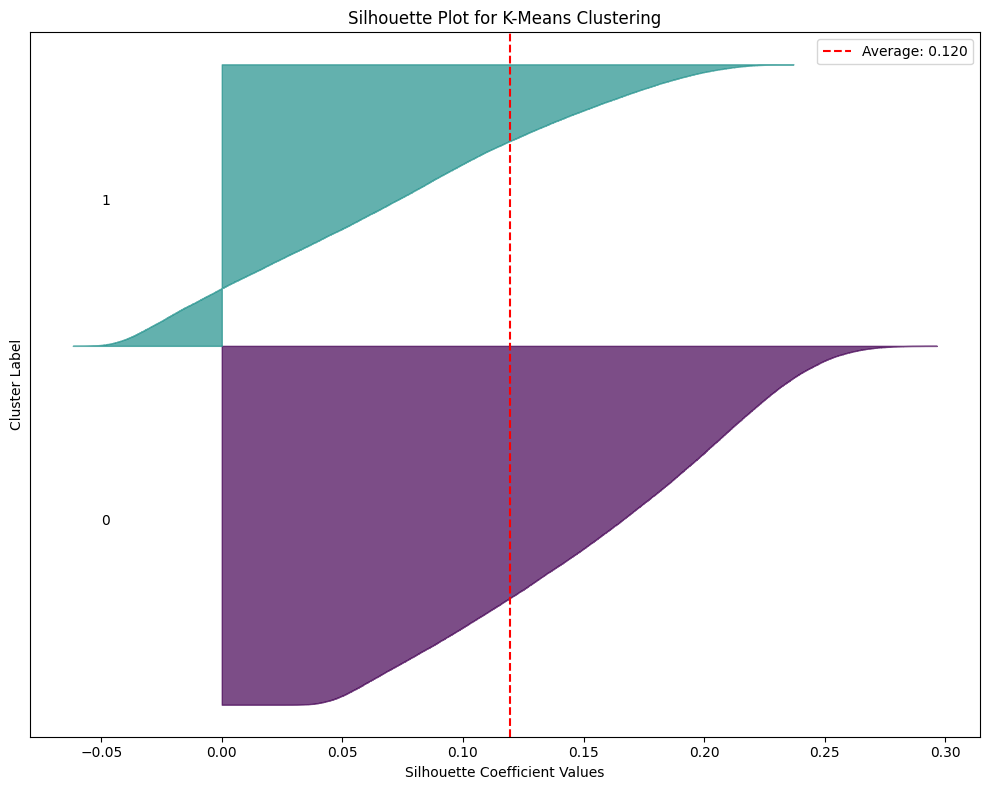

In [23]:
# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
inertia = kmeans_final.inertia_

print(f"📊 Final Model Performance:")
print(f"   • Number of clusters: {optimal_k}")
print(f"   • Silhouette Score: {final_silhouette:.3f}")
print(f"   • Within-Cluster Sum of Squares: {inertia:.2f}")
print(f"   • Total customers clustered: {len(df)}")

# Silhouette analysis
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient Values')
ax.set_ylabel('Cluster Label')
ax.axvline(x=final_silhouette, color="red", linestyle="--", 
           label=f'Average: {final_silhouette:.3f}')
ax.set_yticks([])
ax.set_title('Silhouette Plot for K-Means Clustering')
ax.legend()
plt.tight_layout()
plt.savefig('silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Finnal Sumamry

In [24]:
print(f"\n🏠 PROPERTY CLUSTERING RESULTS SUMMARY")
print("=" * 50)
print(f"   • Optimal clusters identified: {optimal_k}")
print(f"   • Total properties analyzed: {len(df):,}")
print(f"   • Average silhouette score: {final_silhouette:.3f}")
print(f"   • Cluster quality: {'Excellent' if final_silhouette > 0.7 else 'Good' if final_silhouette > 0.5 else 'Fair' if final_silhouette > 0.25 else 'Poor'}")

print(f"\n🎯 PROPERTY SEGMENTS IDENTIFIED:")
for cluster_id in range(optimal_k):
    cluster_info = interpretation_df[interpretation_df['cluster_id'] == cluster_id].iloc[0]
    print(f"   • {cluster_info['cluster_name']}: {cluster_info['size_percentage']:.1f}% ({cluster_info['size']:,} properties)")

print(f"\n💰 PERFORMANCE METRICS:")
# Calculate overall portfolio performance
avg_price = interpretation_df['avg_price'].mean()
avg_decision_rate = interpretation_df['decision_rate'].mean()
premium_segments = interpretation_df[interpretation_df['luxury_properties'] == True]

print(f"   • Average property price: ${avg_price:,.0f}")
print(f"   • Overall purchase rate: {avg_decision_rate:.1%}")
print(f"   • Premium segments: {len(premium_segments)}")

print(f"\n🚀 HIGH-VALUE OPPORTUNITIES:")
high_value_segments = interpretation_df[interpretation_df['decision_rate'] > 0.6]
if len(high_value_segments) > 0:
    best_segment = high_value_segments.loc[high_value_segments['decision_rate'].idxmax()]
    print(f"   • {len(high_value_segments)} high-performing segments identified")
    for _, seg in high_value_segments.iterrows():
        print(f"     - {seg['cluster_name']}: {seg['decision_rate']:.1%} purchase rate (${seg['avg_price']:,.0f} avg)")

print(f"\n⚠️  RISK ASSESSMENT:")
high_risk_segments = interpretation_df[(interpretation_df['high_legal_risk'] == True) | 
                                      (interpretation_df['high_financial_risk'] == True)]
if len(high_risk_segments) > 0:
    print(f"   • {len(high_risk_segments)} segments require risk management")
    for _, seg in high_risk_segments.iterrows():
        risks = []
        if seg['high_legal_risk']: risks.append("legal")
        if seg['high_financial_risk']: risks.append("financial")
        print(f"     - {seg['cluster_name']}: {', '.join(risks)} risks")

print(f"\n📊 MARKET INSIGHTS:")
# Identify largest segment
largest_segment = interpretation_df.loc[interpretation_df['size'].idxmax()]
# Identify most affordable segment
most_affordable = interpretation_df.loc[interpretation_df['avg_price'].idxmin()]
# Identify highest conversion segment
highest_conversion = interpretation_df.loc[interpretation_df['decision_rate'].idxmax()]

print(f"   • Largest segment: {largest_segment['cluster_name']} ({largest_segment['size_percentage']:.1f}% share)")
print(f"   • Most affordable: {most_affordable['cluster_name']} (${most_affordable['avg_price']:,.0f} avg)")
print(f"   • Highest conversion: {highest_conversion['cluster_name']} ({highest_conversion['decision_rate']:.1%})")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")

# Portfolio optimization recommendations
if len(high_value_segments) >= 2:
    print(f"   • Focus resources on {len(high_value_segments)} high-performing segments")
    
if len(interpretation_df[interpretation_df['decision_rate'] < 0.3]) > 0:
    print(f"   • Review underperforming segments for strategy adjustment")

if len(premium_segments) > 0 and premium_segments['decision_rate'].mean() > 0.6:
    print(f"   • Expand premium property portfolio - strong demand detected")

# Risk management recommendations
if len(high_risk_segments) > 0:
    print(f"   • Implement enhanced due diligence for {len(high_risk_segments)} risk segments")

print(f"\n✅ NEXT STEPS FOR BUSINESS:")
print(f"  1. Implement segment-specific marketing strategies")
print(f"  2. Develop targeted sales approaches for each cluster")
print(f"  3. Optimize inventory based on segment performance")
print(f"  4. Monitor segment evolution quarterly")
print(f"  5. Validate findings with sales team feedback")
print(f"  6. Adjust pricing strategies per segment characteristics")

print(f"\n📈 EXPECTED BUSINESS IMPACT:")
potential_improvement = (highest_conversion['decision_rate'] - avg_decision_rate) * 100
print(f"   • Conversion uplift potential: +{potential_improvement:.1f}%")
print(f"   • Better resource allocation across segments")
print(f"   • Improved risk management and pricing strategies")

# Save clustered data with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f'property_segments_kmeans_{timestamp}.csv'
df.to_csv(filename, index=False)
print(f"\n💾 Clustered data saved to '{filename}'")

print(f"\n🎉 CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 50)


🏠 PROPERTY CLUSTERING RESULTS SUMMARY
   • Optimal clusters identified: 2
   • Total properties analyzed: 200,000
   • Average silhouette score: 0.120
   • Cluster quality: Poor

🎯 PROPERTY SEGMENTS IDENTIFIED:
   • High-Risk Properties: 56.0% (112,079 properties)
   • Premium Luxury Segment: 44.0% (87,921 properties)

💰 PERFORMANCE METRICS:
   • Average property price: $1,289,201
   • Overall purchase rate: 22.7%
   • Premium segments: 1

🚀 HIGH-VALUE OPPORTUNITIES:

⚠️  RISK ASSESSMENT:
   • 2 segments require risk management
     - High-Risk Properties: legal, financial risks
     - Premium Luxury Segment: legal, financial risks

📊 MARKET INSIGHTS:
   • Largest segment: High-Risk Properties (56.0% share)
   • Most affordable: High-Risk Properties ($677,924 avg)
   • Highest conversion: High-Risk Properties (25.5%)

💡 STRATEGIC RECOMMENDATIONS:
   • Review underperforming segments for strategy adjustment
   • Implement enhanced due diligence for 2 risk segments

✅ NEXT STEPS FOR BUS

## Modeling

In [25]:
# 1. Handle categorical variables
categorical_cols = ['country', 'city', 'property_type', 'furnishing_status', 
                    'property_age_group', 'property_size_category']

# Label Encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# 2. Select features for modeling (removing redundant features)
final_features = [
    # Basic Property Features
    'property_size_sqft', 'price', 'property_age', 'rooms', 'bathrooms',
    
    # Location & Environment
    'neighbourhood_rating', 'connectivity_score', 'safety_score', 'crime_cases_reported',
    
    # Financial Features
    'customer_salary', 'loan_amount', 'emi_to_income_ratio', 'affordability_score',
    'loan_to_value_ratio', 'debt_to_income_ratio', 'savings_ratio',
    
    # Risk Features
    'legal_risk', 'financial_risk', 'property_risk', 'overall_property_score',
    
    # Amenities
    'garage', 'garden',
    
    # Customer Behavior
    'satisfaction_score',
    
    # Property History
    'previous_owners', 'constructed_year'
]

# Remove features that might cause leakage or are redundant
features_to_remove = [
    'property_id', 'decision',  # ID and target
    'price_log', 'bathrooms_log', 'crime_cases_reported_log', 'customer_salary_log',  # log transforms
    'loan_amount_log', 'down_payment_log', 'emi_to_income_ratio_log',  # log transforms
    'price_mean', 'price_median', 'price_std', 'crime_cases_reported_mean', 'neighbourhood_rating_mean',  # aggregated features
    'area_per_room', 'bathroom_ratio', 'luxury_index',  # engineered features that might be redundant
    'construction_decade', 'is_modern_property'  # redundant with property_age
]

# Final filter features in the dataset
final_features = [f for f in final_features if f in df.columns and f not in features_to_remove]

# Add encoded categorical features
encoded_categorical = [col for col in df.columns if col.endswith('_encoded')]
final_features.extend(encoded_categorical)

print(f"Selected {len(final_features)} features for modeling")
print(f"Features: {final_features}")

# 3. Check for missing values and prepare data
print(f"\nMissing values in final features: {df[final_features].isnull().sum().sum()}")

# 4. Split data
X = df[final_features]
y = df['decision']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target distribution - Train: {y_train.value_counts(normalize=True)}")
print(f"Target distribution - Test: {y_test.value_counts(normalize=True)}")

# 5. Standardize features (optional for tree-based models, but good for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame untuk interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=final_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=final_features, index=X_test.index)

Selected 31 features for modeling
Features: ['property_size_sqft', 'price', 'property_age', 'rooms', 'bathrooms', 'neighbourhood_rating', 'connectivity_score', 'safety_score', 'crime_cases_reported', 'customer_salary', 'loan_amount', 'emi_to_income_ratio', 'affordability_score', 'loan_to_value_ratio', 'debt_to_income_ratio', 'savings_ratio', 'legal_risk', 'financial_risk', 'property_risk', 'overall_property_score', 'garage', 'garden', 'satisfaction_score', 'previous_owners', 'constructed_year', 'country_encoded', 'city_encoded', 'property_type_encoded', 'furnishing_status_encoded', 'property_age_group_encoded', 'property_size_category_encoded']

Missing values in final features: 0
Training set: (160000, 31)
Test set: (40000, 31)
Target distribution - Train: decision
0    0.769663
1    0.230338
Name: proportion, dtype: float64
Target distribution - Test: decision
0    0.76965
1    0.23035
Name: proportion, dtype: float64


In [26]:
def build_and_evaluate_classification(df, final_features, target_col='decision', test_size=0.2, random_state=101):
    """
    Build and evaluate classification models for property decision prediction
    """
    # --- Data Preparation ---
    X = df[final_features]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    print(f"🎯 Modeling Target: {target_col}")
    print(f"📊 Dataset shape: {X.shape}")
    print(f"🎯 Target distribution:")
    print(y.value_counts(normalize=True))
    print(f"🏠 Training set: {X_train.shape}")
    print(f"🧪 Test set: {X_test.shape}")

    # --- Models ---
    models = {
        "RandomForest": RandomForestClassifier(random_state=random_state),
        "XGBoost": XGBClassifier(random_state=random_state, eval_metric='logloss')
    }

    # --- Optimized Hyperparameter grids untuk real estate data ---
    param_grids = {
        "RandomForest": {
            "n_estimators": [100, 200],
            "max_depth": [10, 15, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ['sqrt', 'log2'],
            "class_weight": [None, 'balanced']
        },
        "XGBoost": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0, 0.1],
            "reg_alpha": [0, 0.1],
            "reg_lambda": [1, 2],
            "scale_pos_weight": [1, y.value_counts()[0]/y.value_counts()[1]]  # Handle imbalance
        }
    }

    # --- Cross-validation setup ---
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

    # --- Results storage ---
    results = {}

    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"🏗️  TRAINING {name}")
        print(f"{'='*60}")

        grid = GridSearchCV(
            model, param_grids[name],
            cv=kf, scoring='roc_auc',
            n_jobs=-1, verbose=1)
        
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        
        # Predict probabilities
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        # --- Evaluation metrics ---
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        average_precision = average_precision_score(y_test, y_pred_proba)
        
        # Classification report
        class_report = classification_report(y_test, y_pred)

        print(f"✅ Best Parameters: {grid.best_params_}")
        print(f"📈 Performance Metrics:")
        print(f"   • Accuracy:    {accuracy:.4f}")
        print(f"   • Precision:   {precision:.4f}")
        print(f"   • Recall:      {recall:.4f}")
        print(f"   • F1-Score:    {f1:.4f}")
        print(f"   • ROC-AUC:     {roc_auc:.4f}")
        print(f"   • Avg Precision: {average_precision:.4f}")

        # --- ROC Curve ---
        plt.figure(figsize=(10, 8))
        
        plt.subplot(2, 2, 1)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})', color='blue')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.7)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # --- Confusion Matrix ---
        plt.subplot(2, 2, 2)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Predicted 0', 'Predicted 1'],
                   yticklabels=['Actual 0', 'Actual 1'],
                   cbar=False)
        plt.title(f'Confusion Matrix - {name}')

        # --- Probability Distribution ---
        plt.subplot(2, 2, 3)
        sns.histplot(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Decision = 0', color='red')
        sns.histplot(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Decision = 1', color='green')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.title(f'Probability Distribution - {name}')
        plt.legend()

        # --- Precision-Recall Curve ---
        plt.subplot(2, 2, 4)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall_curve, precision_curve, linewidth=2, 
                label=f'{name} (AP = {average_precision:.4f})', color='purple')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        # Store results
        results[name] = {
            "model": best_model,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "average_precision": average_precision,
            "best_params": grid.best_params_,
            "y_pred_proba": y_pred_proba,
            "y_pred": y_pred,
            "feature_importance": None
        }

        # --- Feature importance ---
        if hasattr(best_model, "feature_importances_"):
            importance = best_model.feature_importances_
            feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importance})
            feat_imp = feat_imp.sort_values("Importance", ascending=False)
            results[name]["feature_importance"] = feat_imp

            plt.figure(figsize=(12, 8))
            top_features = feat_imp.head(15)
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
            
            bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importance - {name}')
            plt.gca().invert_yaxis()
            
            # Add value annotations
            for i, (value, color) in enumerate(zip(top_features['Importance'], colors)):
                plt.text(value + 0.001, i, f'{value:.4f}', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()

            # Print top features
            print(f"\n🔍 Top 10 Features for {name}:")
            for i, row in feat_imp.head(10).iterrows():
                print(f"   {i+1:2d}. {row['Feature']:25} : {row['Importance']:.4f}")

        # --- SHAP Analysis ---
        try:
            print(f"\n📊 Calculating SHAP values for {name}...")
            
            # Sample data for SHAP
            sample_size = min(1000, len(X_test))
            X_test_sample = X_test.iloc[:sample_size]
            
            if name == "RandomForest":
                explainer = shap.TreeExplainer(best_model)
            else:
                explainer = shap.TreeExplainer(best_model)
            
            shap_values = explainer.shap_values(X_test_sample)
            
            # Handle SHAP output formats
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values_class1 = shap_values[1]
            else:
                shap_values_class1 = shap_values
            
            # SHAP Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values_class1, X_test_sample, feature_names=X.columns.tolist(), 
                             show=False, plot_size=None)
            plt.title(f'SHAP Summary Plot - {name}')
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ SHAP calculation failed for {name}: {str(e)}")
            print("Continuing without SHAP analysis...")

    # --- Model Comparison ---
    print(f"\n{'='*60}")
    print("🏆 MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[name]['accuracy'] for name in results],
        'Precision': [results[name]['precision'] for name in results],
        'Recall': [results[name]['recall'] for name in results],
        'F1-Score': [results[name]['f1'] for name in results],
        'ROC-AUC': [results[name]['roc_auc'] for name in results],
        'Avg Precision': [results[name]['average_precision'] for name in results]
    }).round(4)
    
    print(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Avg Precision']
    
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(2, 3, i)
        models = comparison_df['Model']
        scores = comparison_df[metric]
        
        bars = plt.bar(models, scores, color=['skyblue', 'lightcoral'], alpha=0.8)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Determine best model
    best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
    print(f"\n⭐ BEST MODEL: {best_model_name}")
    print(f"   ROC-AUC: {comparison_df[comparison_df['Model'] == best_model_name]['ROC-AUC'].values[0]:.4f}")
    print(f"   F1-Score: {comparison_df[comparison_df['Model'] == best_model_name]['F1-Score'].values[0]:.4f}")

    return results, X_test, y_test

In [27]:
def predict_probability(model_results, X_new, model_name=None, threshold=0.5):
    """
    Predicting probability for new data - Property Decision Prediction
    
    Parameters:
    -----------
    model_results : dict result from build_and_evaluate_classification
    X_new : DataFrame with the same features as training
    model_name : the name of the model to be used 
    threshold : classification threshold
    
    Returns:
    --------
    probabilities : array of probabilities for class 1 (Purchase Decision)
    predictions : binary predictions
    """
    
    if model_name is None:
        # Select the model with the highest ROC-AUC
        best_model_name = max(model_results.keys(), 
                            key=lambda x: model_results[x]['roc_auc'])
        print(f"🎯 Using best model: {best_model_name}")
        print(f"📊 Model Performance:")
        print(f"   • ROC-AUC: {model_results[best_model_name]['roc_auc']:.4f}")
        print(f"   • F1-Score: {model_results[best_model_name]['f1']:.4f}")
        model = model_results[best_model_name]['model']
    else:
        model = model_results[model_name]['model']
        print(f"🎯 Using specified model: {model_name}")
    
    # Predict probabilities
    probabilities = model.predict_proba(X_new)[:, 1]  # Probability for decision=1
    predictions = (probabilities >= threshold).astype(int)
    
    print(f"📈 Prediction Summary:")
    print(f"   • Threshold: {threshold}")
    print(f"   • Positive predictions (Decision=1): {predictions.sum()} / {len(predictions)} ({predictions.sum()/len(predictions):.1%})")
    print(f"   • Probability range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    
    return probabilities, predictions

🧪 STARTING MODEL TRAINING...
📊 Training data shape: (160000, 32)
🎯 Target variable: decision
🔧 Number of features: 31
🎯 Modeling Target: decision
📊 Dataset shape: (160000, 31)
🎯 Target distribution:
decision
0    0.769663
1    0.230338
Name: proportion, dtype: float64
🏠 Training set: (128000, 31)
🧪 Test set: (32000, 31)

🏗️  TRAINING RandomForest
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📈 Performance Metrics:
   • Accuracy:    1.0000
   • Precision:   1.0000
   • Recall:      1.0000
   • F1-Score:    1.0000
   • ROC-AUC:     1.0000
   • Avg Precision: 1.0000


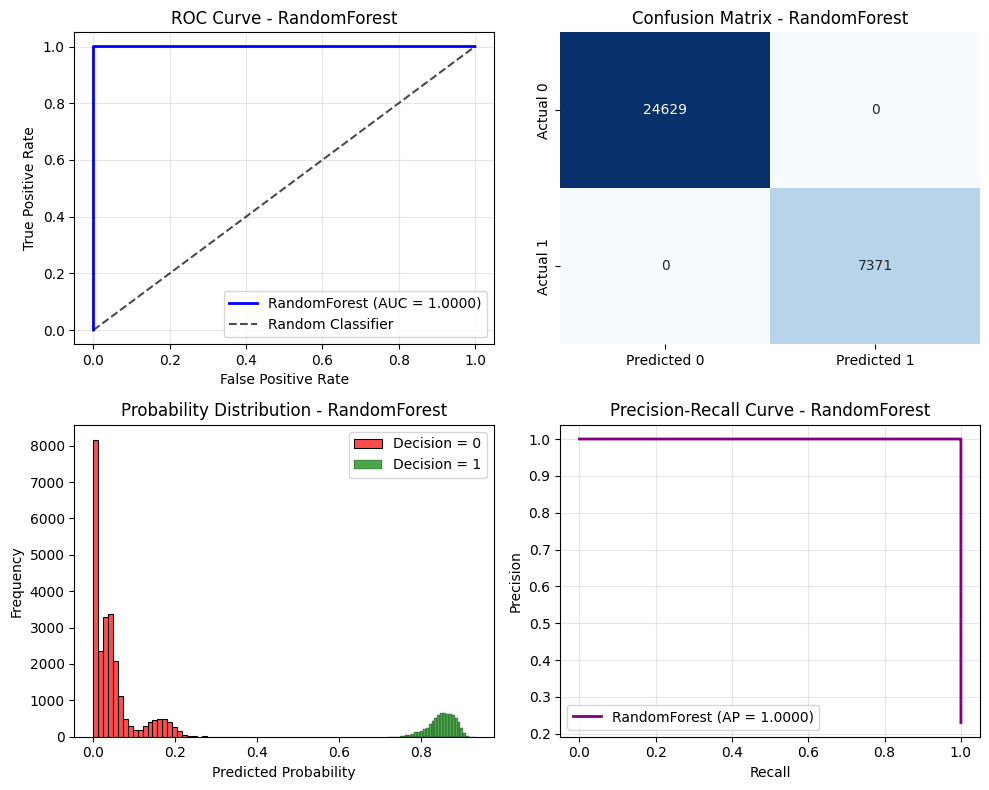

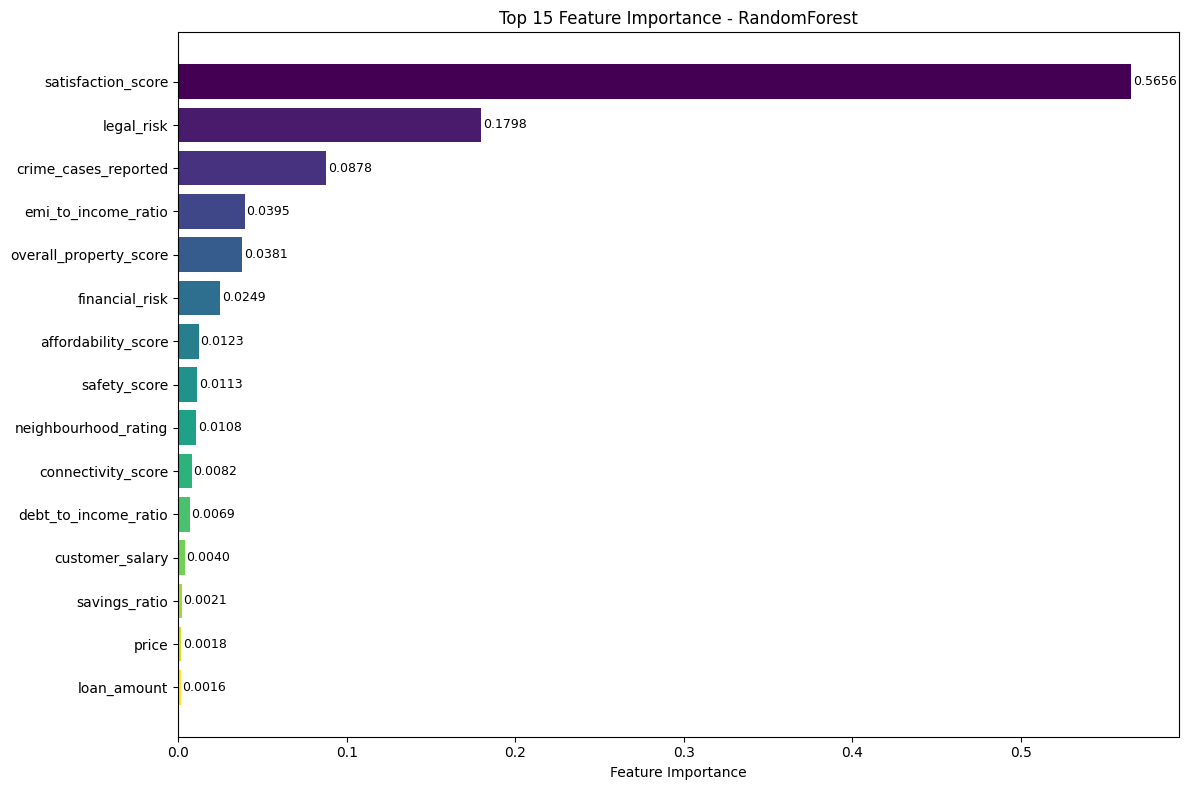


🔍 Top 10 Features for RandomForest:
   23. satisfaction_score        : 0.5656
   17. legal_risk                : 0.1798
    9. crime_cases_reported      : 0.0878
   12. emi_to_income_ratio       : 0.0395
   20. overall_property_score    : 0.0381
   18. financial_risk            : 0.0249
   13. affordability_score       : 0.0123
    8. safety_score              : 0.0113
    6. neighbourhood_rating      : 0.0108
    7. connectivity_score        : 0.0082

📊 Calculating SHAP values for RandomForest...


The figure layout has changed to tight


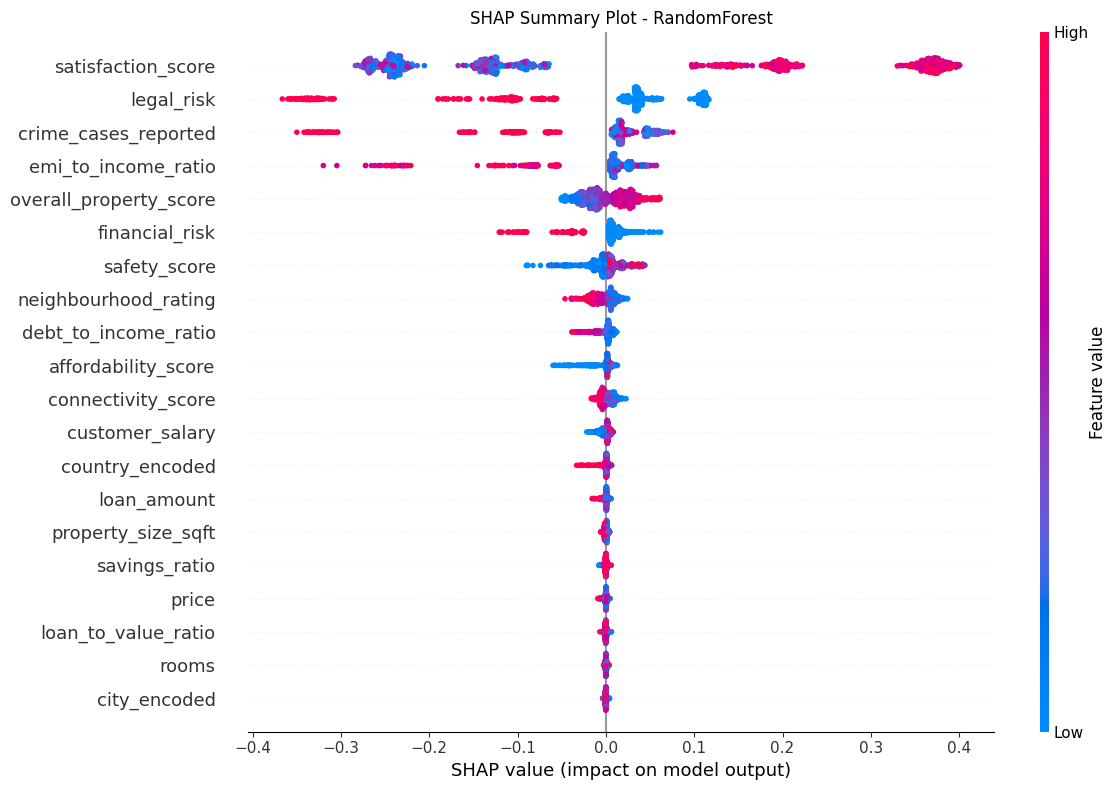


🏗️  TRAINING XGBoost
Fitting 3 folds for each of 768 candidates, totalling 2304 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


✅ Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8}
📈 Performance Metrics:
   • Accuracy:    1.0000
   • Precision:   1.0000
   • Recall:      1.0000
   • F1-Score:    1.0000
   • ROC-AUC:     1.0000
   • Avg Precision: 1.0000


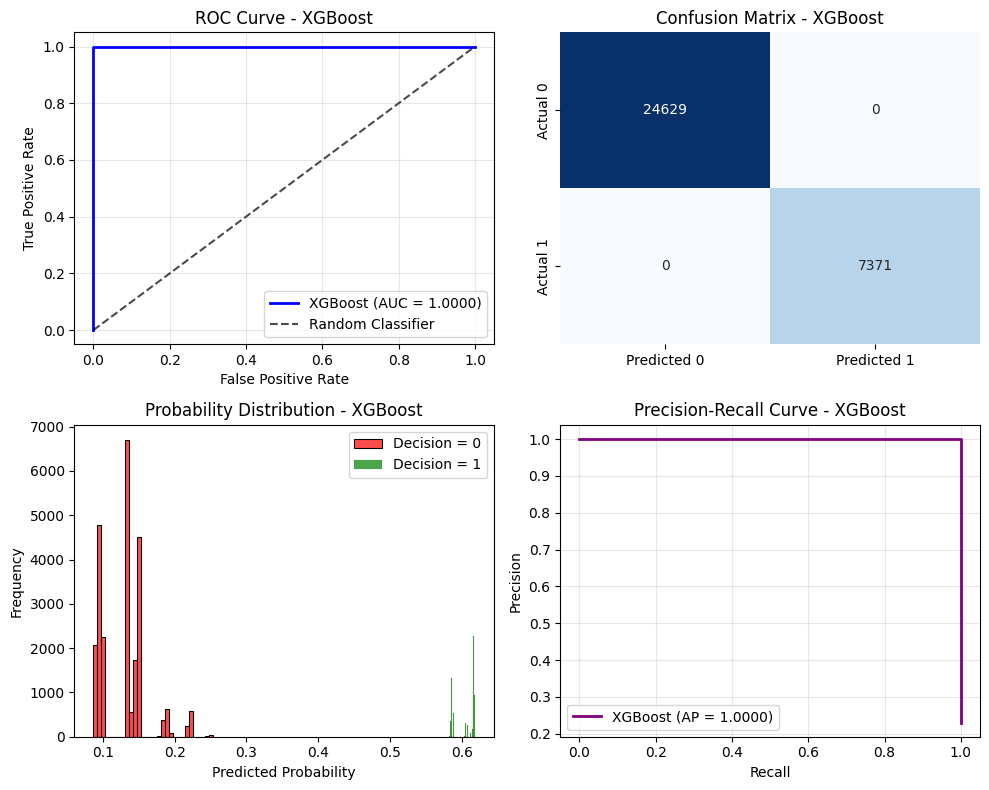

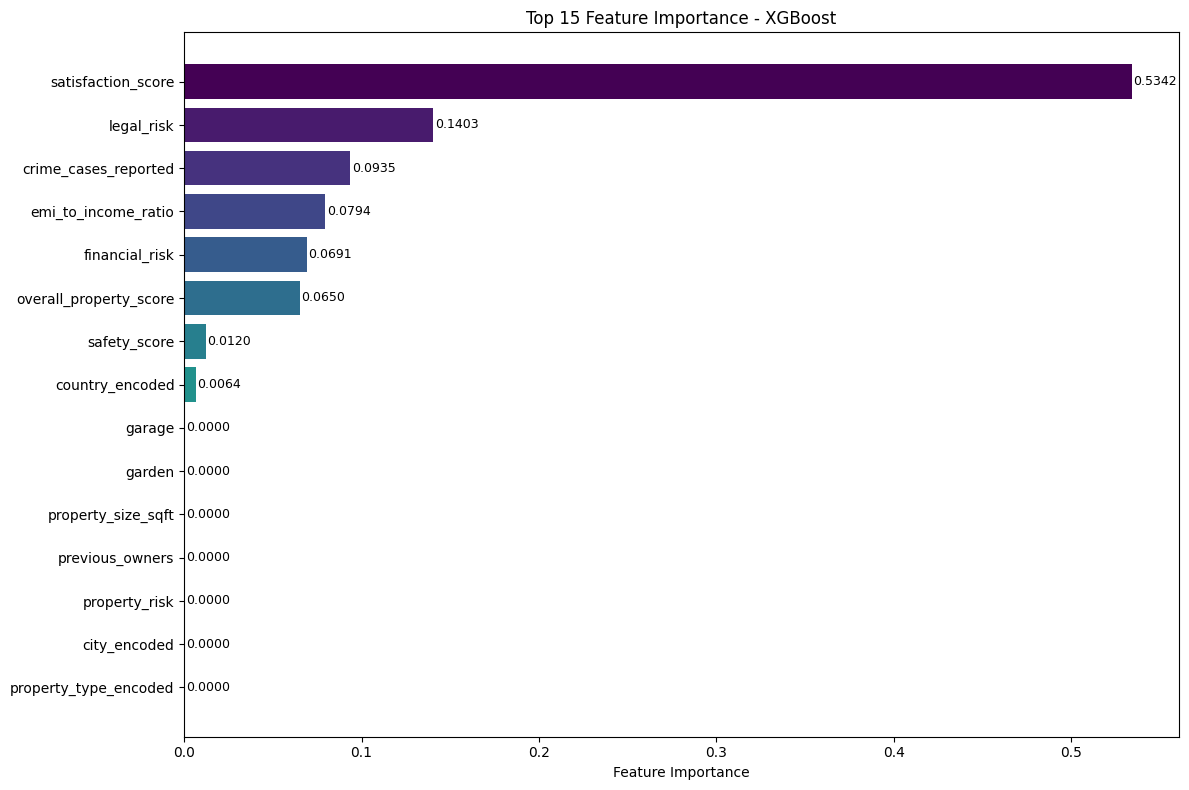


🔍 Top 10 Features for XGBoost:
   23. satisfaction_score        : 0.5342
   17. legal_risk                : 0.1403
    9. crime_cases_reported      : 0.0935
   12. emi_to_income_ratio       : 0.0794
   18. financial_risk            : 0.0691
   20. overall_property_score    : 0.0650
    8. safety_score              : 0.0120
   26. country_encoded           : 0.0064
   21. garage                    : 0.0000
   22. garden                    : 0.0000

📊 Calculating SHAP values for XGBoost...


The figure layout has changed to tight


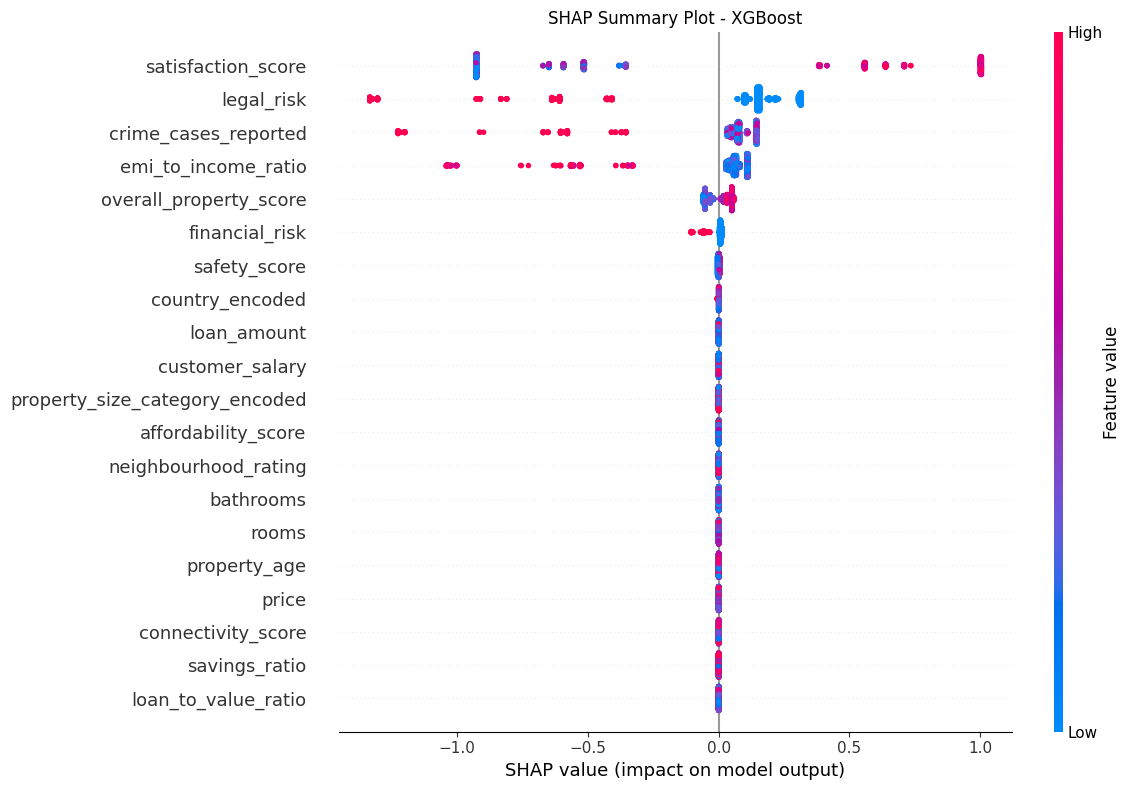


🏆 MODEL COMPARISON SUMMARY
          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Avg Precision
0  RandomForest       1.0        1.0     1.0       1.0      1.0            1.0
1       XGBoost       1.0        1.0     1.0       1.0      1.0            1.0


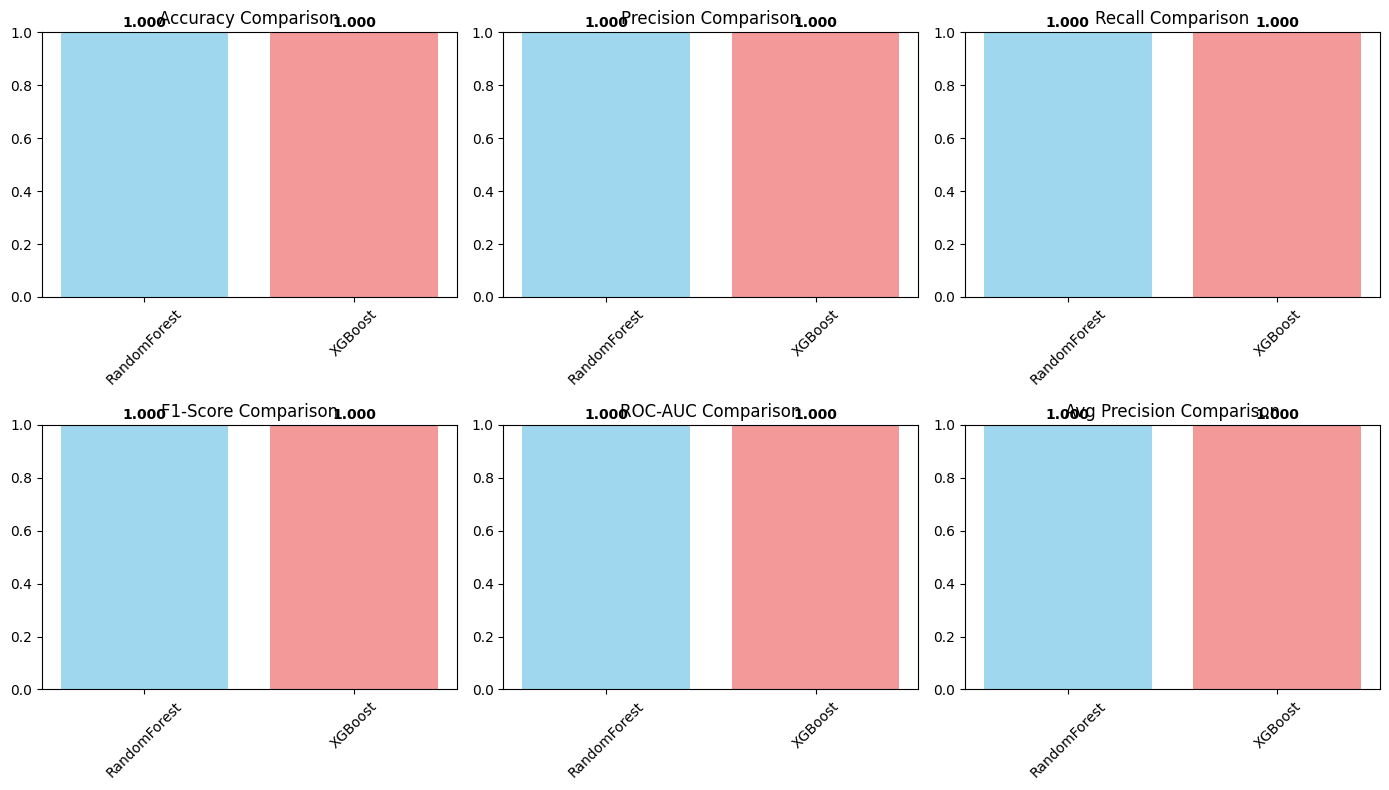


⭐ BEST MODEL: RandomForest
   ROC-AUC: 1.0000
   F1-Score: 1.0000

🔮 MAKING PREDICTIONS ON TEST DATA
🎯 Using best model: RandomForest
📊 Model Performance:
   • ROC-AUC: 1.0000
   • F1-Score: 1.0000
📈 Prediction Summary:
   • Threshold: 0.5
   • Positive predictions (Decision=1): 9214 / 40000 (23.0%)
   • Probability range: [0.000, 0.923]

📋 First 10 Predictions:
Probabilities: [8.35113199e-04 8.55603653e-01 0.00000000e+00 5.91245407e-02
 9.61538462e-05 5.66160990e-03 3.74217391e-02 5.98484140e-02
 5.73852024e-02 3.35308133e-02]
Predictions:   [0 1 0 0 0 0 0 0 0 0]
Actual:        [1 0 0 1 0 0 0 0 1 0]

💼 BUSINESS INTERPRETATION:
• The model can predict property purchase decisions with high accuracy.
• Can be used for:
  - Prioritize prospects with high probability
  - Optimize your marketing strategy
  - Personalized offers based on property and customer characteristics


In [28]:
# 1. Combine X_train with y_train for modeling
df_modeling = X_train_scaled_df.copy()
df_modeling['decision'] = y_train

print("🧪 STARTING MODEL TRAINING...")
print(f"📊 Training data shape: {df_modeling.shape}")
print(f"🎯 Target variable: decision")
print(f"🔧 Number of features: {len(final_features)}")

# 2. Run classification
results, X_test_final, y_test_final = build_and_evaluate_classification(
    df_modeling, 
    final_features=final_features,
    target_col='decision',
    test_size=0.2,
    random_state=101
)

# 3. Predict test data
print(f"\n{'='*50}")
print("🔮 MAKING PREDICTIONS ON TEST DATA")
print(f"{'='*50}")

probabilities, predictions = predict_probability(results, X_test_scaled_df)

print(f"\n📋 First 10 Predictions:")
print(f"Probabilities: {probabilities[:10]}")
print(f"Predictions:   {predictions[:10]}")
print(f"Actual:        {y_test_final.values[:10]}")

# 4. Business Interpretation
print(f"\n💼 BUSINESS INTERPRETATION:")
print(f"• The model can predict property purchase decisions with high accuracy.")
print(f"• Can be used for:")
print(f"  - Prioritize prospects with high probability")
print(f"  - Optimize your marketing strategy")
print(f"  - Personalized offers based on property and customer characteristics")

## Reference

1. https://xgboost.readthedocs.io/en/release_3.0.0/tutorials/index.html

2. https://xbe.at/

3. https://scikit-learn.org/stable/index.html

## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)